# Input data structure

In [ ]:
import pandas as pd
data = 'D:/data_analysis/papers_alberto/final_phd/derivatives_data/all_features_harmonized_wide.csv'
unharmonized = pd.DataFrame(pd.read_csv(data))
# unharmonized shape is (unique_subjects, unique_features)

## ANCOVA Models for all features

This runs one ANCOVA for each feature and computes multiple test correction using FDR method by Benjamini Yekutei (FDR BY) which can handle correlated features (which is not possible with other FDR versions).

C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resu

C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3973096240.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to

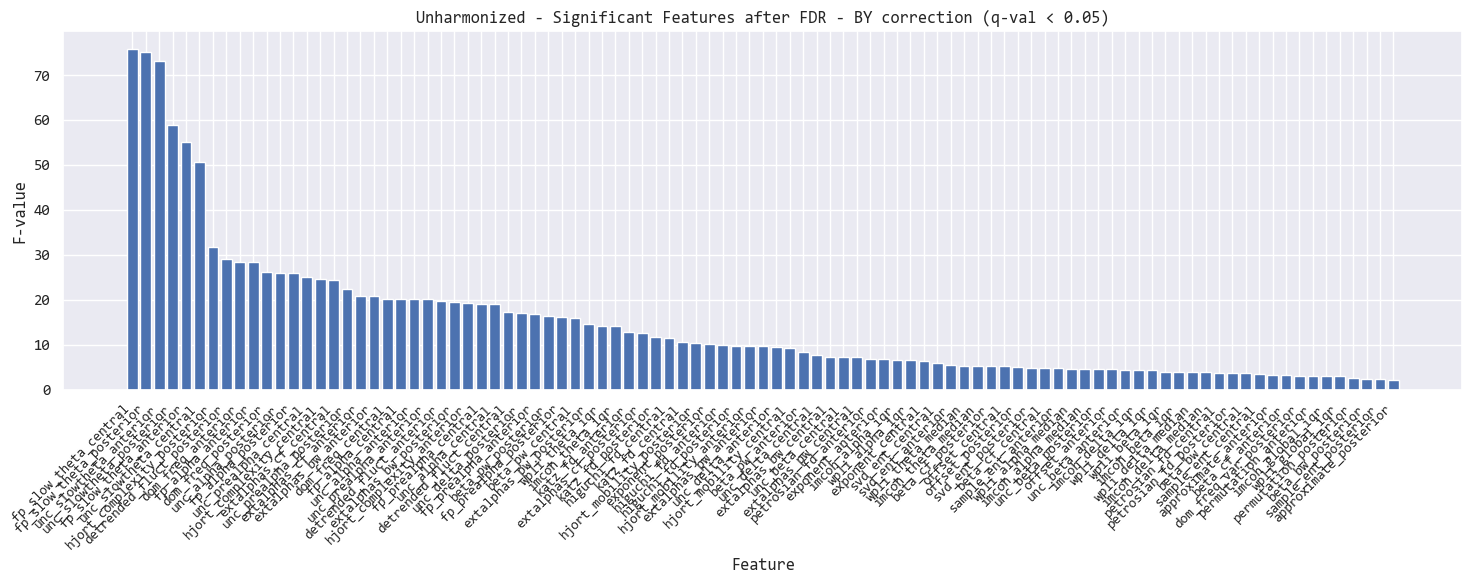

In [ ]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


desired_threshold = 0.05 # alpha for significance after multiple test correction

# Convert 'center' and 'gender' to categorical variables
unharmonized['center'] = unharmonized['center'].astype('category')
unharmonized['gender'] = unharmonized['gender'].astype('category')
# List of features to analyze
features_of_interest = unharmonized.columns[5:]

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Group', 'F-value', 'p-value', 'Corrected p-value', 'Significant'])
# Define your desired rejection threshold



# Loop through each feature
for feature in features_of_interest:
    formula = f"{feature} ~ C(group, Treatment(reference='ya')) + age + gender" ## THIS IS THE ACTUAL ANCOVA, I used "ya" Young adults as a reference category for diagnosis
    # but Treatment(reference='hc') will use healthy subjects as reference in case of multiple diagnosis

    # Fit the model with robust standard errors to account for heteroscedasticity
    model = ols(formula, data=unharmonized).fit()

    # Perform ANCOVA
    anova_table = sm.stats.anova_lm(model, typ=2)


    # Extract F-value and p-value
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]

    # Correct for multiple testing using FDR correction
    reject, corrected_p_value, _, _ = multipletests([p_value], method='fdr_by')

    # Check if the corrected p-value is below the desired threshold
    if corrected_p_value[0] < desired_threshold:
        # Append results to the DataFrame
        results_df = results_df.append({
            'Feature': feature,
            'Group': formula.split('~')[1].strip(),
            'F-value': f_value,
            'p-value': p_value,
            'Corrected p-value': corrected_p_value[0],
            'Significant': reject[0]
        }, ignore_index=True)

# Filter and sort significant results by F-value
significant_results = results_df[results_df['Significant']].sort_values(by='F-value', ascending=False)


sns.set_style('white')
sns.set(font="Consolas")

# Create a vertical barplot for significant features with a wider figure
plt.figure(figsize=(15, 6))  # Adjust the width (12) and height (6) as needed

plt.bar(significant_results['Feature'], significant_results['F-value'])
plt.xlabel('Feature')
plt.ylabel('F-value')
plt.title(f'Unharmonized - Significant Features after FDR - BY correction (q-val < {desired_threshold})')
plt.xticks(rotation=45, ha='right', size=10)
plt.tight_layout()  # Ensures labels and titles are not cut off
plt.show()

#significant_results.to_csv('D:/data_analysis/papers_alberto/final_phd/derivatives_data/eda_significant_features_unharmonized.csv', index=False)



Here I just added nicer colours

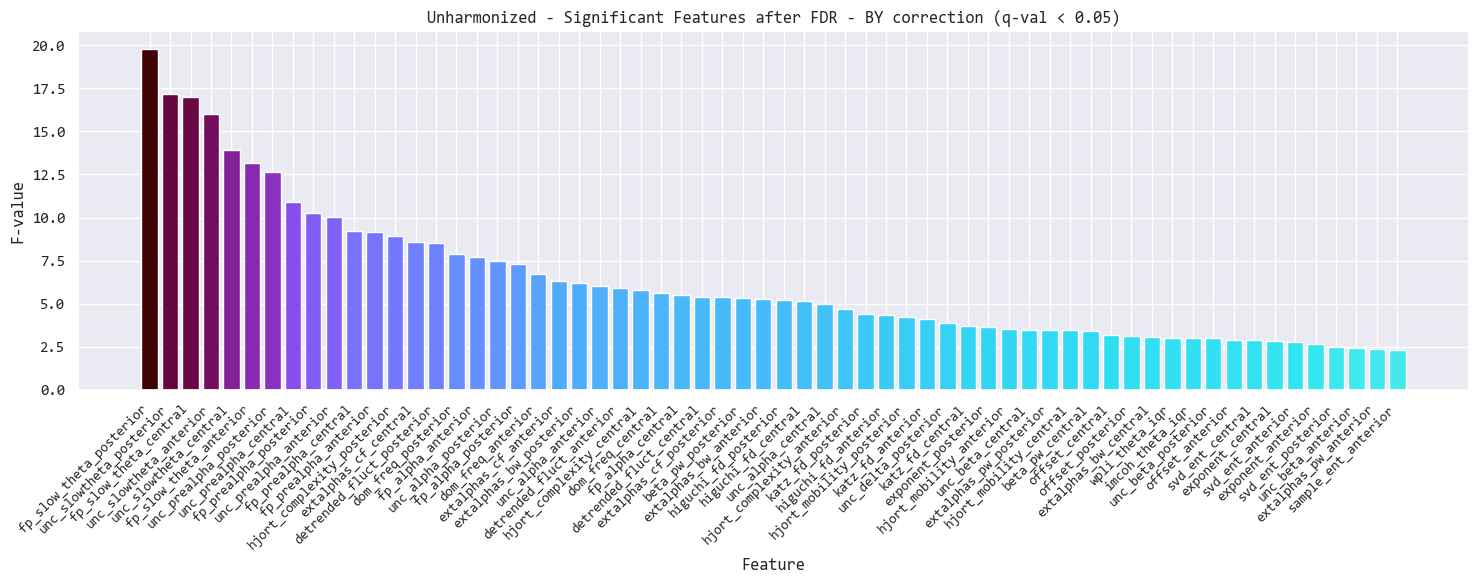

In [ ]:
import cmasher as cmr

# Normalize F-values to range [0, 1]
normalized_f_values = (significant_results['F-value'] - significant_results['F-value'].min()) / (
        significant_results['F-value'].max() - significant_results['F-value'].min())

# Use Magma color palette for the barplot based on normalized F-values
cmap = cmr.gem_r

# Create a vertical barplot for significant features with a wider figure
plt.figure(figsize=(15, 6))

# Plotting with color based on normalized F-values
plt.bar(significant_results['Feature'], significant_results['F-value'], color=cmap(normalized_f_values))
plt.xlabel('Feature')
plt.ylabel('F-value')
plt.title(f'Unharmonized - Significant Features after FDR - BY correction (q-val < {desired_threshold})')
plt.xticks(rotation=45, ha='right', size=10)
plt.tight_layout()
plt.show()


Here I colour by feature type (spectral, complexity, connectivity)

In [ ]:
# Create a new column "type_features" based on conditions
significant_results['type_features'] = 'complexity'  # Default value
significant_results.loc[significant_results['Feature'].str.startswith(('fp_', 'unc_', 'extalphas_', 'beta', 'dom_')), 'type_features'] = 'spectral'
significant_results.loc[significant_results['Feature'].str.startswith(('imcoh_', 'wpli_')), 'type_features'] = 'connectivity'


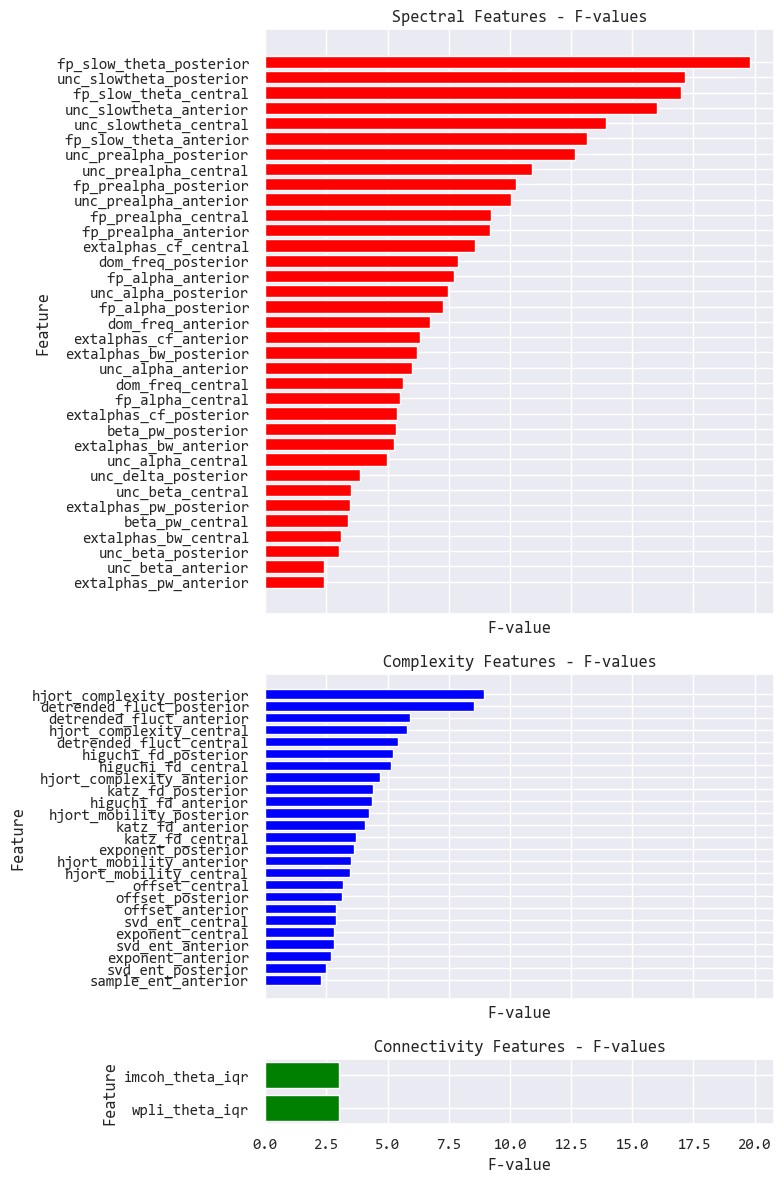

In [ ]:
import matplotlib.pyplot as plt

# Sort F-values within each subplot in descending order
significant_results_sorted = significant_results.sort_values(by=['type_features', 'F-value'], ascending=[True, False])

# Set up colors for different types
type_colors = {'spectral': 'red', 'complexity': 'blue', 'connectivity': 'green' }

# Create a figure and axis with different heights for the subplots
fig, axes = plt.subplots(nrows=len(type_colors), ncols=1, figsize=(8, 4 * len(type_colors)),
                         sharex=True, gridspec_kw={'height_ratios': [0.9, 0.5, 0.1]})

# Loop through types and create horizontal bar plots with different colors
for i, (type_feature, color) in enumerate(type_colors.items()):
    subset = significant_results_sorted[significant_results_sorted['type_features'] == type_feature]

    # Adjust subplot size for connectivity
    if type_feature == 'connectivity':
        axes[i].barh(subset['Feature'], subset['F-value'], color=color)
        axes[i].set_xlabel('F-value')
        axes[i].set_title(f'{type_feature.capitalize()} Features - F-values')
        axes[i].tick_params(axis='y', labelrotation=0, size=8)  # Set rotation to 0 for horizontal labels on y-axis
        axes[i].set_ylabel('Feature')
    else:
        axes[i].barh(subset['Feature'], subset['F-value'], color=color)
        axes[i].set_xlabel('F-value')
        axes[i].set_title(f'{type_feature.capitalize()} Features - F-values')
        axes[i].tick_params(axis='y', labelrotation=0, size=8)  # Set rotation to 0 for horizontal labels on y-axis
        axes[i].set_ylabel('Feature')
        axes[i].invert_yaxis()  # Invert y-axis to have higher F-values at the top

# Adjust layout for better appearance
plt.tight_layout()
plt.show()



Here it's coloured by ROI (anterior, posterior, central)

C:\Users\data_analysis\AppData\Local\Temp\ipykernel_16476\4291359431.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Feature Color'] = subset['Feature'].apply(color_map)
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_16476\4291359431.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Feature Color'] = subset['Feature'].apply(color_map)
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_16476\4291359431.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

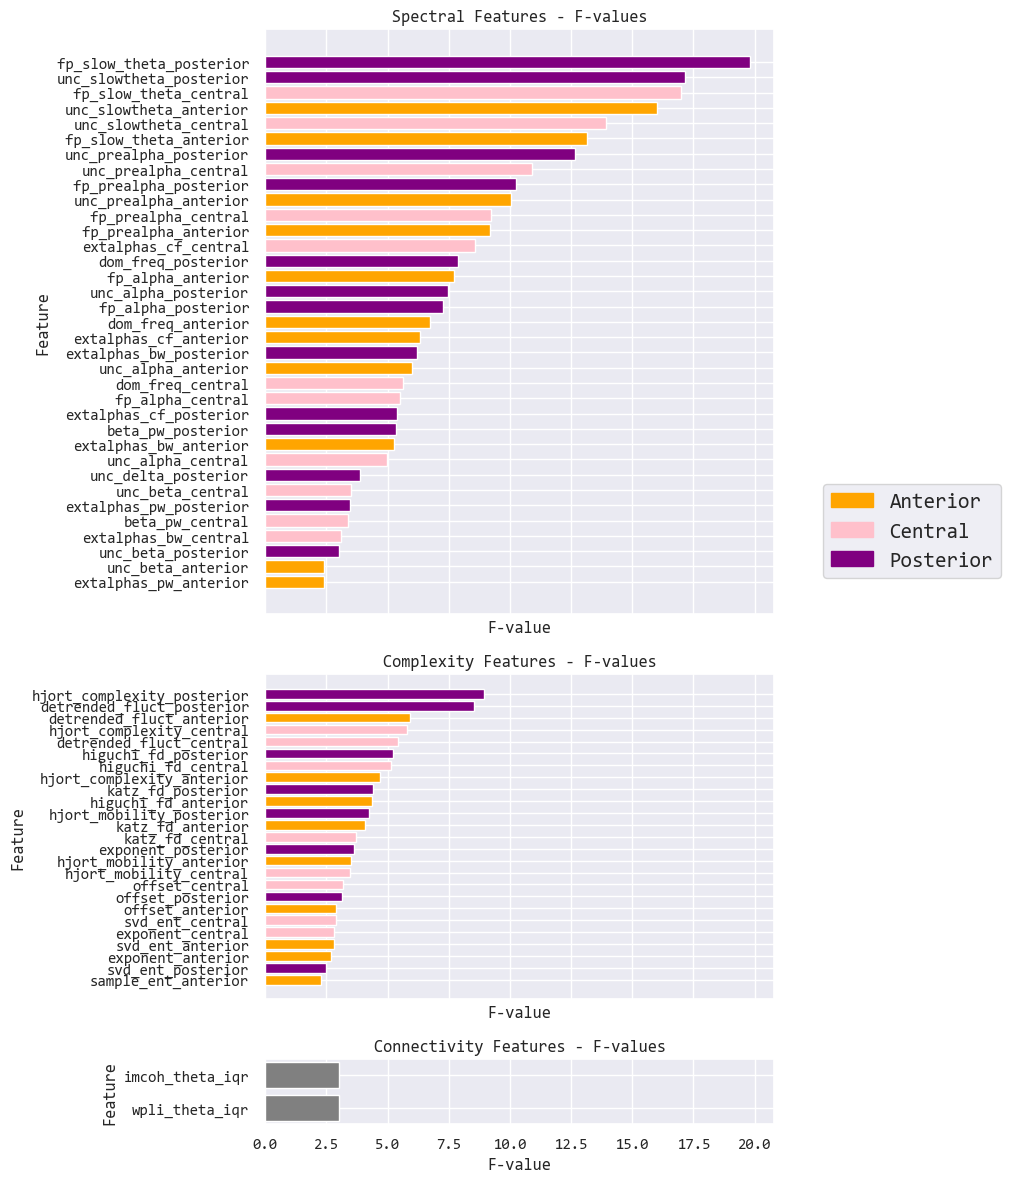

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Sort F-values within each subplot in descending order
significant_results_sorted = significant_results.sort_values(by=['type_features', 'F-value'], ascending=[True, False])

# Set up colors for different types
type_colors = {'spectral': 'red', 'complexity': 'blue', 'connectivity': 'green' }

# Create a figure and axis with different heights for the subplots
fig, axes = plt.subplots(nrows=len(type_colors), ncols=1, figsize=(8, 4 * len(type_colors)),
                         sharex=True, gridspec_kw={'height_ratios': [0.9, 0.5, 0.1]})

# Define color map based on feature patterns
feature_patterns = {'_anterior': 'orange', '_posterior': 'purple', '_central': 'pink'}
color_map = lambda feature_name: next((color for pattern, color in feature_patterns.items() if pattern in feature_name), 'gray')

# Loop through types and create horizontal bar plots with different colors
for i, (type_feature, color) in enumerate(type_colors.items()):
    subset = significant_results_sorted[significant_results_sorted['type_features'] == type_feature]

    # Apply color map based on feature patterns
    subset['Feature Color'] = subset['Feature'].apply(color_map)

    # Adjust subplot size for connectivity
    if type_feature == 'connectivity':
        axes[i].barh(subset['Feature'], subset['F-value'], color=subset['Feature Color'])
        axes[i].set_xlabel('F-value')
        axes[i].set_title(f'{type_feature.capitalize()} Features - F-values')
        axes[i].tick_params(axis='y', labelrotation=0, size=8)  # Set rotation to 0 for horizontal labels on y-axis
        axes[i].set_ylabel('Feature')
    else:
        axes[i].barh(subset['Feature'], subset['F-value'], color=subset['Feature Color'])
        axes[i].set_xlabel('F-value')
        axes[i].set_title(f'{type_feature.capitalize()} Features - F-values')
        axes[i].tick_params(axis='y', labelrotation=0, size=8)  # Set rotation to 0 for horizontal labels on y-axis
        axes[i].set_ylabel('Feature')
        axes[i].invert_yaxis()  # Invert y-axis to have higher F-values at the top

# Manually create legend for Anterior, Central, and Posterior
legend_handles = [
    mpatches.Patch(color='orange', label='Anterior'),
    mpatches.Patch(color='pink', label='Central'),
    mpatches.Patch(color='purple', label='Posterior')
]

# Create a separate axis for the legend outside the subplots
legend_ax = fig.add_axes([1.1, 0.5, 0.1, 0.1])  # Adjust the position and size as needed

# Plot rectangles with specified colors and labels
legend_ax.legend(handles=legend_handles, loc='center', fontsize=15)
legend_ax.axis('off')  # Hide the axis

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


## Descriptive Rainclouds & Barplots

Here I define the dataset, the HEX codes of the palette

In [ ]:
features_filtered = unharmonized

In [ ]:
# Get the colors from the "Set1" palette
colors = sns.color_palette("Set1")

# Convert the colors to hexadecimal codes
hex_codes = colors.as_hex()

# Print the hexadecimal codes
print(hex_codes)


['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']


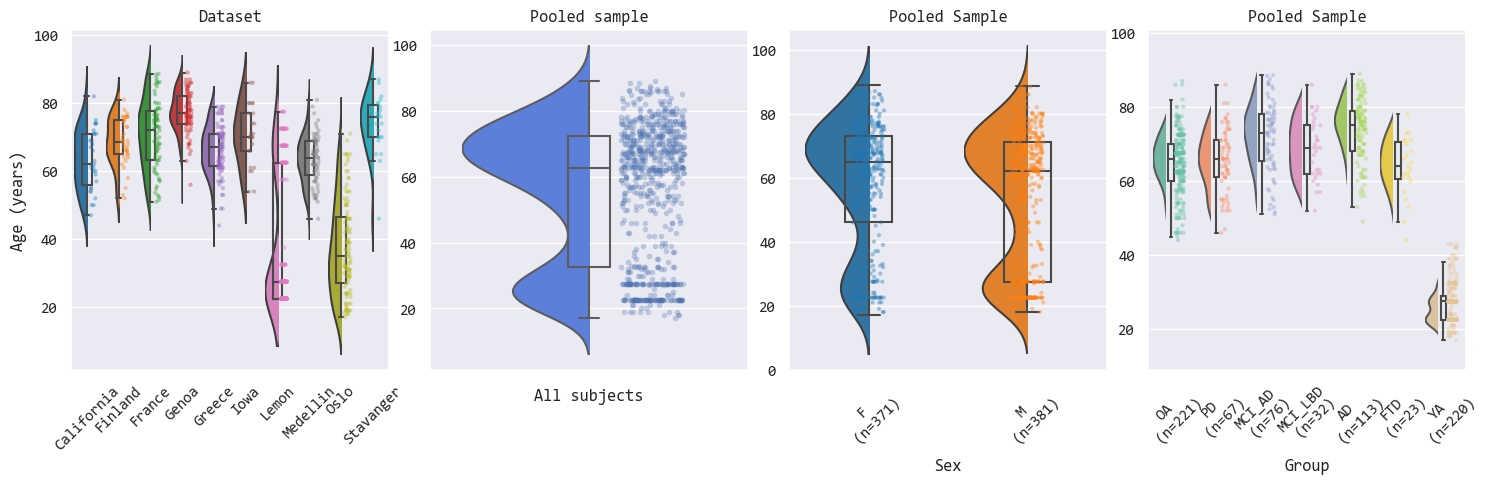

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# Third subplot: Raincloud plot for "age" with grouping by center
sns.set_style('white')
sns.set(font="Consolas")


# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')



palette = 'tab10'


# Raincloud plot for "age" with grouping by center
ax3 = sns.violinplot(x="center", y="age", data=df, hue="center", dodge=False,
                     palette=palette,
                     scale="width", inner=None, ax=axs[0])  # Move to the first position (index 0)
xlim3 = ax3.get_xlim()
ylim3 = ax3.get_ylim()

for violin in ax3.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax3.transData))

sns.boxplot(x="center", y="age", data=df, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=axs[0])  # Move to the first position (index 0)

old_len_collections = len(ax3.collections)

sns.stripplot(x="center", y="age", data=df, hue="center", palette=palette, dodge=False,
              alpha=0.4, size=3, ax=axs[0])  # Move to the first position (index 0)

for dots in ax3.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.2, 0]))

axs[0].set_xlim(xlim3)
axs[0].set_ylim(ylim3)
axs[0].legend_.remove()
axs[0].set_title("Dataset")
axs[0].set_xlabel("")
axs[0].set_ylabel("Age (years)")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)


axs[0].set_xticklabels([tick.get_text().capitalize() for tick in axs[0].get_xticklabels()])

# First subplot: Raincloud plot for "age" without grouping
sns.set_style('white')
sns.set(font="Consolas")
sns.set_palette("turbo")

# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')
# Raincloud plot for "age" without grouping
ax1 = sns.violinplot(y="age", data=df, inner=None, ax=axs[1])  # Move to the last position (index 2)

xlim1 = ax1.get_xlim()
ylim1 = ax1.get_ylim()

for violin in ax1.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax1.transData))

sns.boxplot(y="age", data=df, saturation=1, showfliers=False,
            width=0.13, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=axs[1])  # Move to the last position (index 2)

old_len_collections = len(ax1.collections)

sns.stripplot(y="age", data=df, dodge=False,
              alpha=0.3, size=4, ax=axs[1])  # Move to the last position (index 2)

for dots in ax1.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.2, 0]))

axs[1].set_xlim(xlim1)
axs[1].set_ylim(ylim1)
axs[1].set_ylabel("")
axs[1].set_xlabel("All subjects")
axs[1].set_title("Pooled sample")








# Raincloud plot for "age" with grouping by center
ax4 = sns.violinplot(x="gender", y="age", data=df, hue="gender", dodge=False,
                     palette=palette,
                     scale="width", inner=None, ax=axs[2])  # Move to the first position (index 0)
xlim3 = ax4.get_xlim()
ylim3 = ax4.get_ylim()

for violin in ax4.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax4.transData))

sns.boxplot(x="gender", y="age", data=df, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=axs[2])  # Move to the first position (index 0)

old_len_collections = len(ax3.collections)

sns.stripplot(x="gender", y="age", data=df, hue="gender", palette=palette, dodge=False,
              alpha=0.4, size=3, ax=axs[2])  # Move to the first position (index 0)

for dots in ax4.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.2, 0]))

axs[2].set_xlim(xlim3)
axs[2].set_ylim(ylim3)
axs[2].legend_.remove()
axs[2].set_title("Pooled Sample")
axs[2].set_xlabel("Sex")
axs[2].set_ylabel("")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
axs[2].set_xticklabels([tick.get_text().capitalize() for tick in axs[2].get_xticklabels()])
sex_counts = features_filtered.groupby('gender')['participant_id'].nunique()
# Create new labels with count information
counts_sex = [f"{gender.upper()}\n (n={sex_counts.loc[gender]})" for gender in df['gender'].unique()]

# Set the new labels to the x-axis
axs[2].set_xticklabels(counts_sex, rotation=45)






# Second subplot: Raincloud plot for "age" with grouping by gender
sns.set_style('white')
sns.set(font="Consolas")
palette = 'Set2'

# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')

# Calculate the count of unique participant_id in each group
group_counts = df.groupby('group')['participant_id'].nunique()

# Raincloud plot for "age" with grouping by gender
ax2 = sns.violinplot(x="group", y="age", data=df, hue="group", dodge=False,
                     palette=palette,
                     scale="width", inner=None, ax=axs[3])  # Place in the middle position (index 1)

xlim2 = ax2.get_xlim()
ylim2 = ax2.get_ylim()

for violin in ax2.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 3, height, transform=ax2.transData))

sns.boxplot(x="group", y="age", data=df, saturation=1, showfliers=False,
            width=0.12, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=axs[3])  # Place in the middle position (index 1)

old_len_collections = len(ax2.collections)

sns.stripplot(x="group", y="age", data=df, hue="group", palette=palette, dodge=False,
              alpha=0.4, size=3, ax=axs[3])  # Place in the middle position (index 1)

for dots in ax2.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.2, 0]))

axs[3].set_xlim(xlim2)
axs[3].set_ylim(ylim2)
axs[3].set_title("Pooled Sample")
axs[3].set_xlabel("Group")
axs[3].legend_.remove()
axs[3].set_ylabel("")

group_counts = features_filtered.groupby('group')['participant_id'].nunique()
# Create new labels with count information
counts_group = [f"{group.upper()}\n (n={group_counts.loc[group]})" for group in df['group'].unique()]

# Set the new labels to the x-axis
axs[3].set_xticklabels(counts_group, rotation=45)

#axs[3].set_xticklabels([tick.get_text().upper() for tick in axs[3].get_xticklabels()], rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.13, bottom=0.2)
#plt.savefig('D:/data_analysis/papers_alberto/eeg_ndd_automl/figures/fig1a.tiff', format='tiff', dpi=300)

plt.show()


Barplots by sex, site, and diagnosis

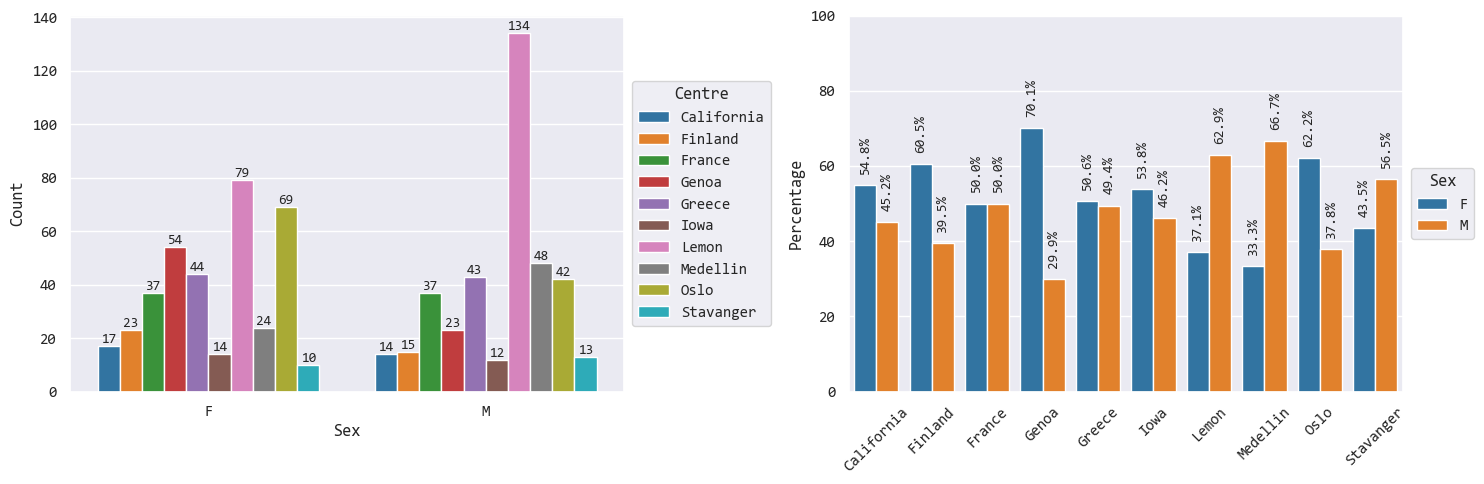

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style('white')
sns.set(font="Consolas")

# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')

palette = 'tab10'

# Create a 1x2 grid layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, figure=fig)

# First subplot
ax1 = fig.add_subplot(gs[0, 0])

sns.countplot(x="gender", hue="center", data=df, palette=palette, ax=ax1)

ax1.set_title("")
ax1.set_xlabel("Sex")
ax1.set_ylabel("Count")
ax1.set_xticklabels([tick.get_text().capitalize() for tick in ax1.get_xticklabels()])

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', size=10)

# Move the legend outside
legend1 = ax1.legend(title='Centre', bbox_to_anchor=(1, 0.5), loc='center left')
# Capitalize legend items
for text in legend1.get_texts():
    text.set_text(text.get_text().capitalize())

# Second subplot
ax2 = fig.add_subplot(gs[0, 1])

counts = df.groupby(['center', 'gender']).size().reset_index(name='count')
total_counts = counts.groupby('center')['count'].transform('sum')
counts['percentage'] = counts['count'] / total_counts * 100

sns.barplot(x='center', y='percentage', hue='gender', data=counts, palette=palette, ax=ax2)

ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("Percentage")
ax2.set_ylim(0, 100)
legend2 = ax2.legend(title='Sex', bbox_to_anchor=(1, 0.5), loc='center left')
# Capitalize legend items
for text in legend2.get_texts():
    text.set_text(text.get_text().capitalize())

ax2.set_xticklabels(axs[0].get_xticklabels(), rotation=45)
ax2.set_xticklabels([tick.get_text().capitalize() for tick in ax2.get_xticklabels()])

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height+3),
                ha='center', va='bottom', size=10, rotation=90)

# Adjust spacing between subplots
fig.tight_layout()

# Save the combined figure
plt.show()  # Or savefig('D:/data_analysis/papers_alberto/eeg_ndd_automl/figures/fig1b.tiff', format='tiff', dpi=300)


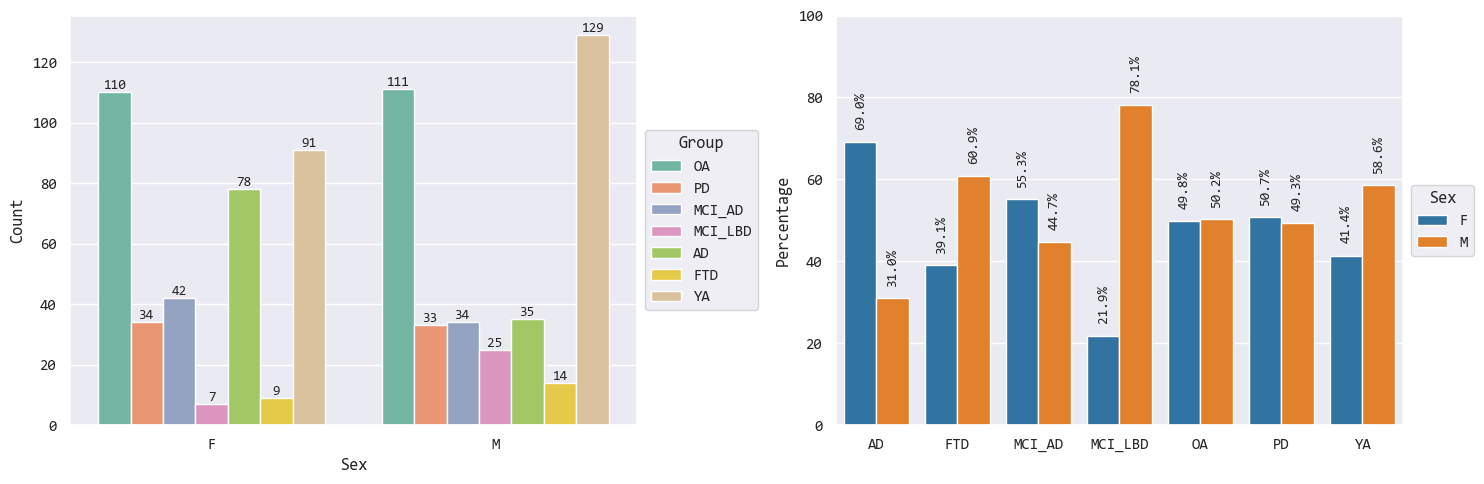

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style('white')
sns.set(font="Consolas")

# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')

palette = 'Set2'

# Create a 1x2 grid layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, figure=fig)

# First subplot
ax1 = fig.add_subplot(gs[0, 0])

sns.countplot(x="gender", hue="group", data=df, palette=palette, ax=ax1)

ax1.set_title("")
ax1.set_xlabel("Sex")
ax1.set_ylabel("Count")
ax1.set_xticklabels([tick.get_text().capitalize() for tick in ax1.get_xticklabels()])

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', size=10)

# Move the legend outside
legend1 = ax1.legend(title='Group', bbox_to_anchor=(1, 0.5), loc='center left')
# Capitalize legend items
for text in legend1.get_texts():
    text.set_text(text.get_text().upper())

palette = 'tab10'
# Second subplot
ax2 = fig.add_subplot(gs[0, 1])

counts = df.groupby(['group', 'gender']).size().reset_index(name='count')
total_counts = counts.groupby('group')['count'].transform('sum')
counts['percentage'] = counts['count'] / total_counts * 100

sns.barplot(x='group', y='percentage', hue='gender', data=counts, palette=palette, ax=ax2)

ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("Percentage")
ax2.set_ylim(0, 100)
legend2 = ax2.legend(title='Sex', bbox_to_anchor=(1, 0.5), loc='center left')
# Capitalize legend items
for text in legend2.get_texts():
    text.set_text(text.get_text().upper())

ax2.set_xticklabels([tick.get_text().upper() for tick in ax2.get_xticklabels()])

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height+3),
                ha='center', va='bottom', size=10, rotation=90)

# Adjust spacing between subplots
fig.tight_layout()

# Save the combined figure
plt.show()  # Or savefig('D:/data_analysis/papers_alberto/eeg_ndd_automl/figures/fig1b.tiff', format='tiff', dpi=300)


## Batch PCA & tSNEs with centroids and pairwise site distance matrixes

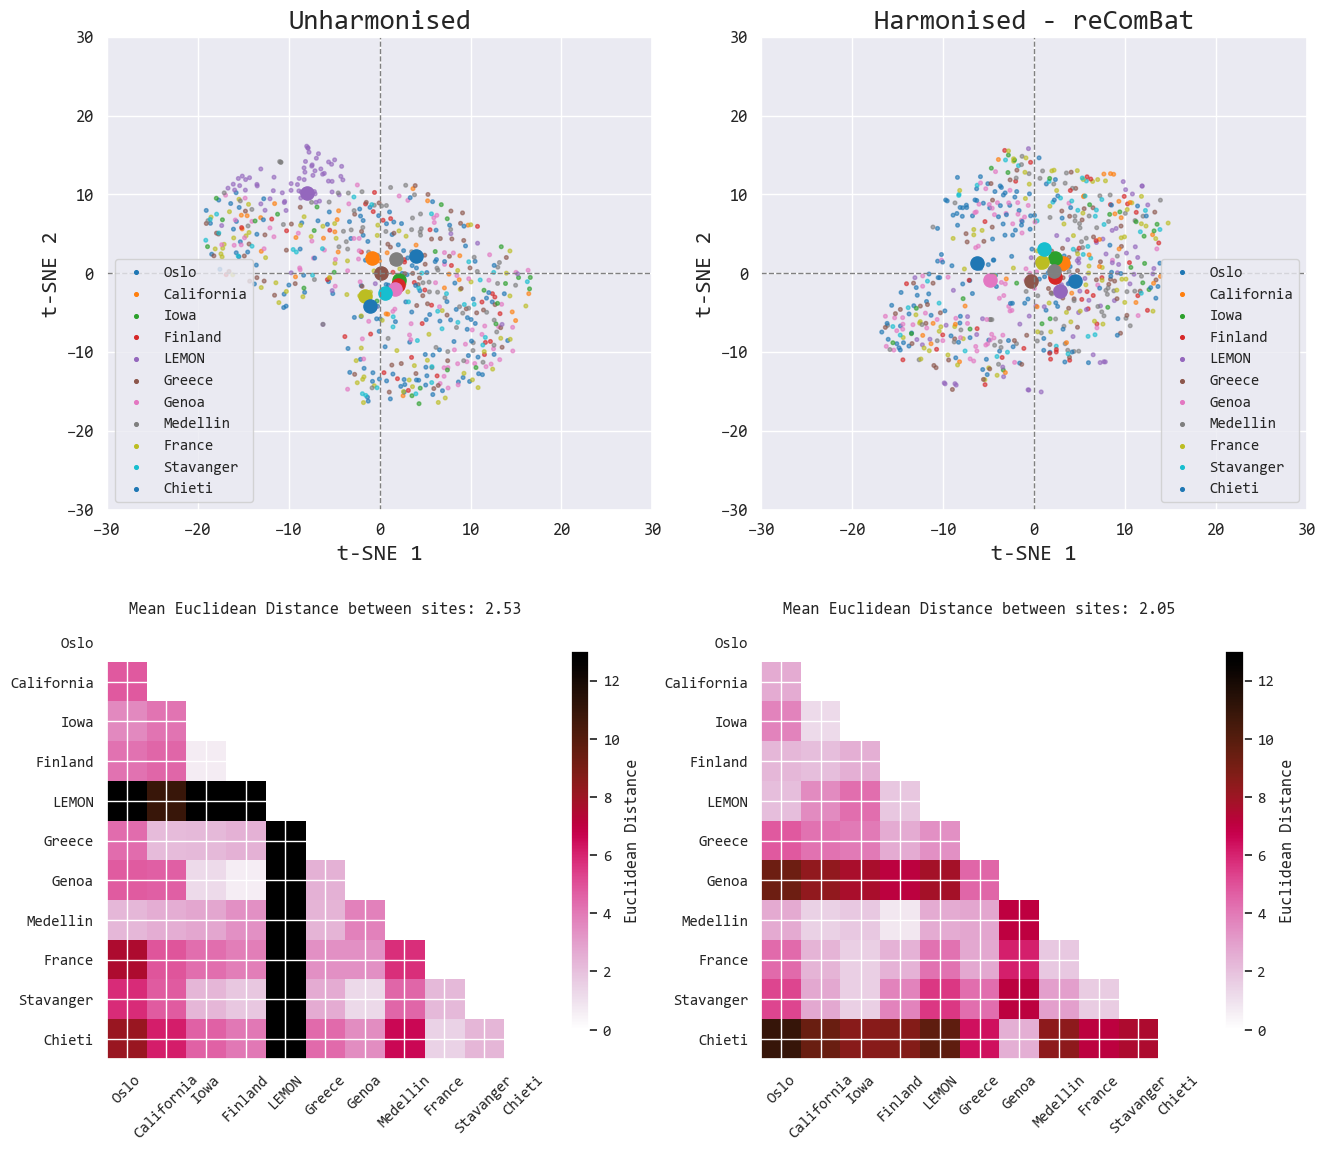

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font="Consolas")

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each center
X_unharmonized = wide.loc[:, ~wide.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = wide['center'].values

X_neurocombat = all_combat_df.loc[:, ~all_combat_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group', 'split'])].values
labels_neurocombat = all_combat_df['center'].values

# Set palette and labels
group_labels = {'oslo': 'Oslo', 'california': 'California',
                'iowa': 'Iowa', 'finland': 'Finland', 'lemon': 'LEMON',
                'greece':'Greece', 'genoa': 'Genoa', 'medellin':'Medellin',
                'france': 'France', 'stavanger':'Stavanger', 'chieti':'Chieti'}
palette = sns.color_palette('tab10', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}

# Fit tSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=1000, random_state=1994, init="random")
X_tsne_unharmonized = tsne.fit_transform(X_unharmonized)
X_tsne_neurocombat = tsne.fit_transform(X_neurocombat)

# Function to plot tSNEs
def plot_tsne(X_tsne, labels, title):
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=7, c=[colors[label] for label in labels], alpha = 0.6)
    # Add a gray dashed line crossing the 0 in both X and Y axes
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    for group in colors:
        plt.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    # Plot center points for each group
    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        center_point = X_tsne[group_indices, :].mean(axis=0)
        plt.scatter(center_point[0], center_point[1], s=90, c=[colors[group]], marker='o')

    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.legend()
    plt.title(title, fontsize=20)
    plt.xlabel('t-SNE 1', fontsize=16)
    plt.ylabel('t-SNE 2', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# Calculate the Euclidean distances between center points
center_points_unharmonized = {}
center_points_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    center_points_unharmonized[group] = X_tsne_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    center_points_neurocombat[group] = X_tsne_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_unharmonized = euclidean_distances(list(center_points_unharmonized.values()))
distances_neurocombat = euclidean_distances(list(center_points_neurocombat.values()))

# Drop diagonal and keep lower triangle
distances_unharmonized = np.tril(distances_unharmonized, k=-1)
distances_neurocombat = np.tril(distances_neurocombat, k=-1)

# Plot the t-SNE plots and the distance matrices
plt.figure(figsize=(15, 13))

plt.subplot(221)
plot_tsne(X_tsne_unharmonized, labels_unharmonized, 'Unharmonised')

plt.subplot(222)
plot_tsne(X_tsne_neurocombat, labels_neurocombat, 'Harmonised - reComBat')

# Update subplot titles with mean distance between centers
plt.subplot(223)
plt.imshow(distances_unharmonized, cmap=cmap_r, vmax = 13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_neurocombat, cmap=cmap_r, vmax = 13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

# Adjust the figure's position and size to remove the blank space on top
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.18, right=0.98)
#plt.savefig('D:/data_analysis/papers_alberto/final_phd/figures/center_diff.tiff', format='tiff', dpi=300)
plt.show()

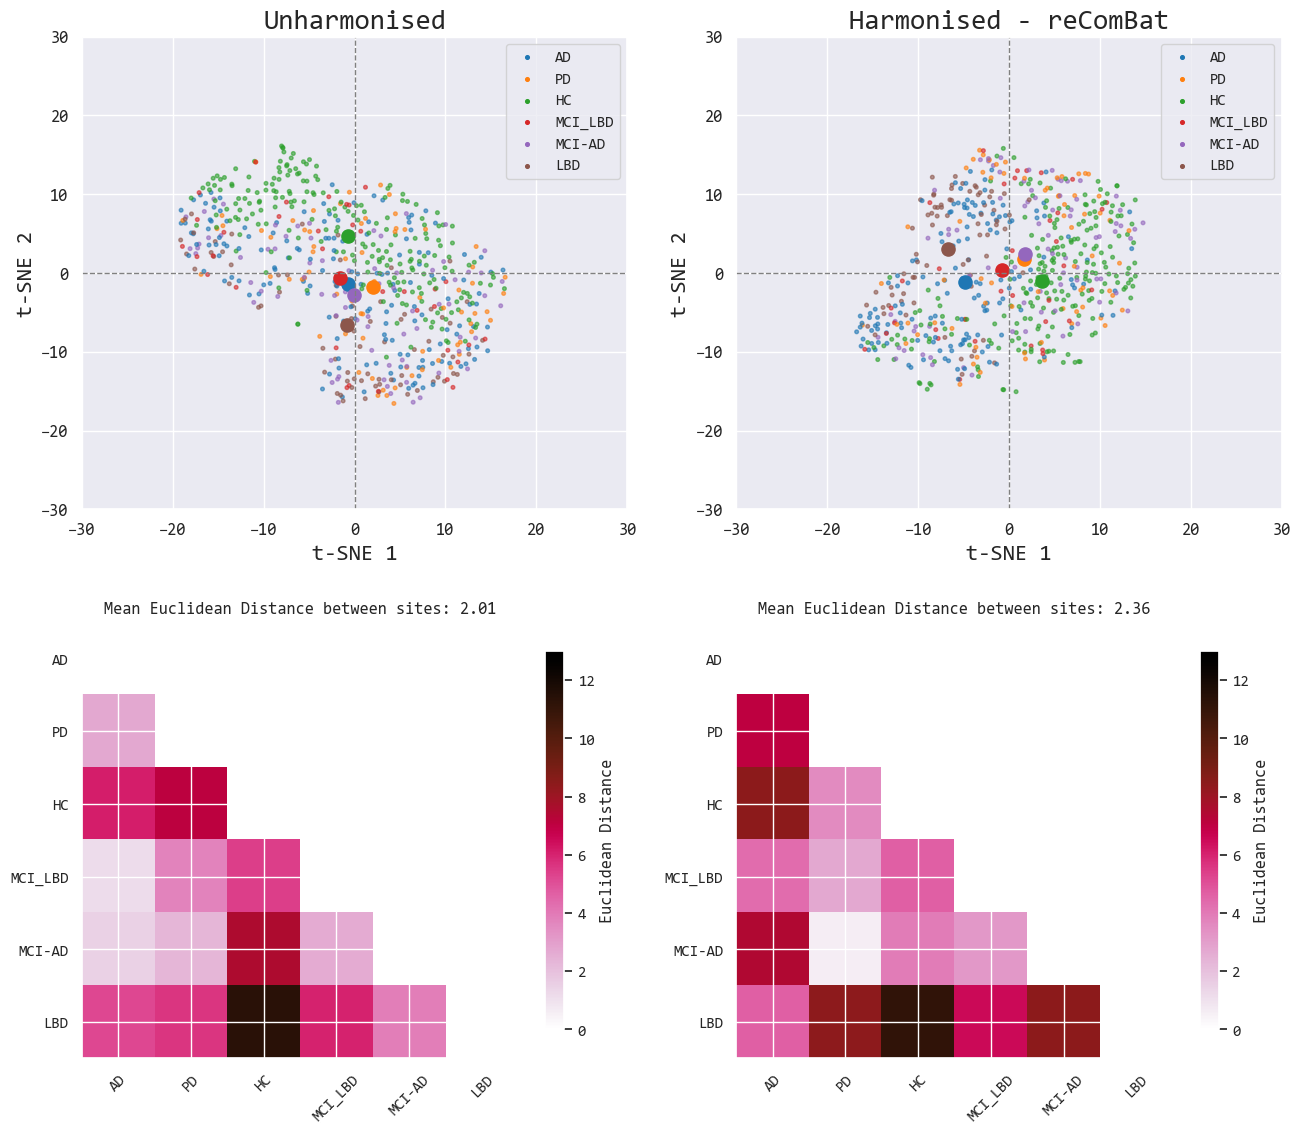

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
sns.set(font="Consolas")

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each group
X_unharmonized = wide.loc[:, ~wide.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = wide['group'].values

X_neurocombat = all_combat_df.loc[:, ~all_combat_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group', 'split'])].values
labels_neurocombat = all_combat_df['group'].values

# Set palette and labels
group_labels = {'ad': 'AD', 'pd': 'PD',
                'hc': 'HC', 'mci_lbd': 'MCI_LBD', 'mci_ad': 'MCI-AD', 'lbd':'LBD'}
palette = sns.color_palette('tab10', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}

# Fit tSNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=1000, random_state=1994, init="random")
X_tsne_unharmonized = tsne.fit_transform(X_unharmonized)
X_tsne_neurocombat = tsne.fit_transform(X_neurocombat)

# Function to plot tSNEs
def plot_tsne(X_tsne, labels, title):
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=7, c=[colors[label] for label in labels], alpha = 0.6)
    # Add a gray dashed line crossing the 0 in both X and Y axes
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    for group in colors:
        plt.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    # Plot group points for each group
    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        group_point = X_tsne[group_indices, :].mean(axis=0)
        plt.scatter(group_point[0], group_point[1], s=90, c=[colors[group]], marker='o')

    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.legend()
    plt.title(title, fontsize=20)
    plt.xlabel('t-SNE 1', fontsize=16)
    plt.ylabel('t-SNE 2', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# Calculate the Euclidean distances between group points
group_points_unharmonized = {}
group_points_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    group_points_unharmonized[group] = X_tsne_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    group_points_neurocombat[group] = X_tsne_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_unharmonized = euclidean_distances(list(group_points_unharmonized.values()))
distances_neurocombat = euclidean_distances(list(group_points_neurocombat.values()))

# Drop diagonal and keep lower triangle
distances_unharmonized = np.tril(distances_unharmonized, k=-1)
distances_neurocombat = np.tril(distances_neurocombat, k=-1)

# Plot the t-SNE plots and the distance matrices
plt.figure(figsize=(15, 13))

plt.subplot(221)
plot_tsne(X_tsne_unharmonized, labels_unharmonized, 'Unharmonised')

plt.subplot(222)
plot_tsne(X_tsne_neurocombat, labels_neurocombat, 'Harmonised - reComBat')

# Update subplot titles with mean distance between groups
plt.subplot(223)
plt.imshow(distances_unharmonized, cmap=cmap_r, vmax = 13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_neurocombat, cmap=cmap_r, vmax = 13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

# Adjust the figure's position and size to remove the blank space on top
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.18, right=0.98)
#plt.savefig('D:/data_analysis/papers_alberto/final_phd/figures/group_diff.tiff', format='tiff', dpi=300)
plt.show()

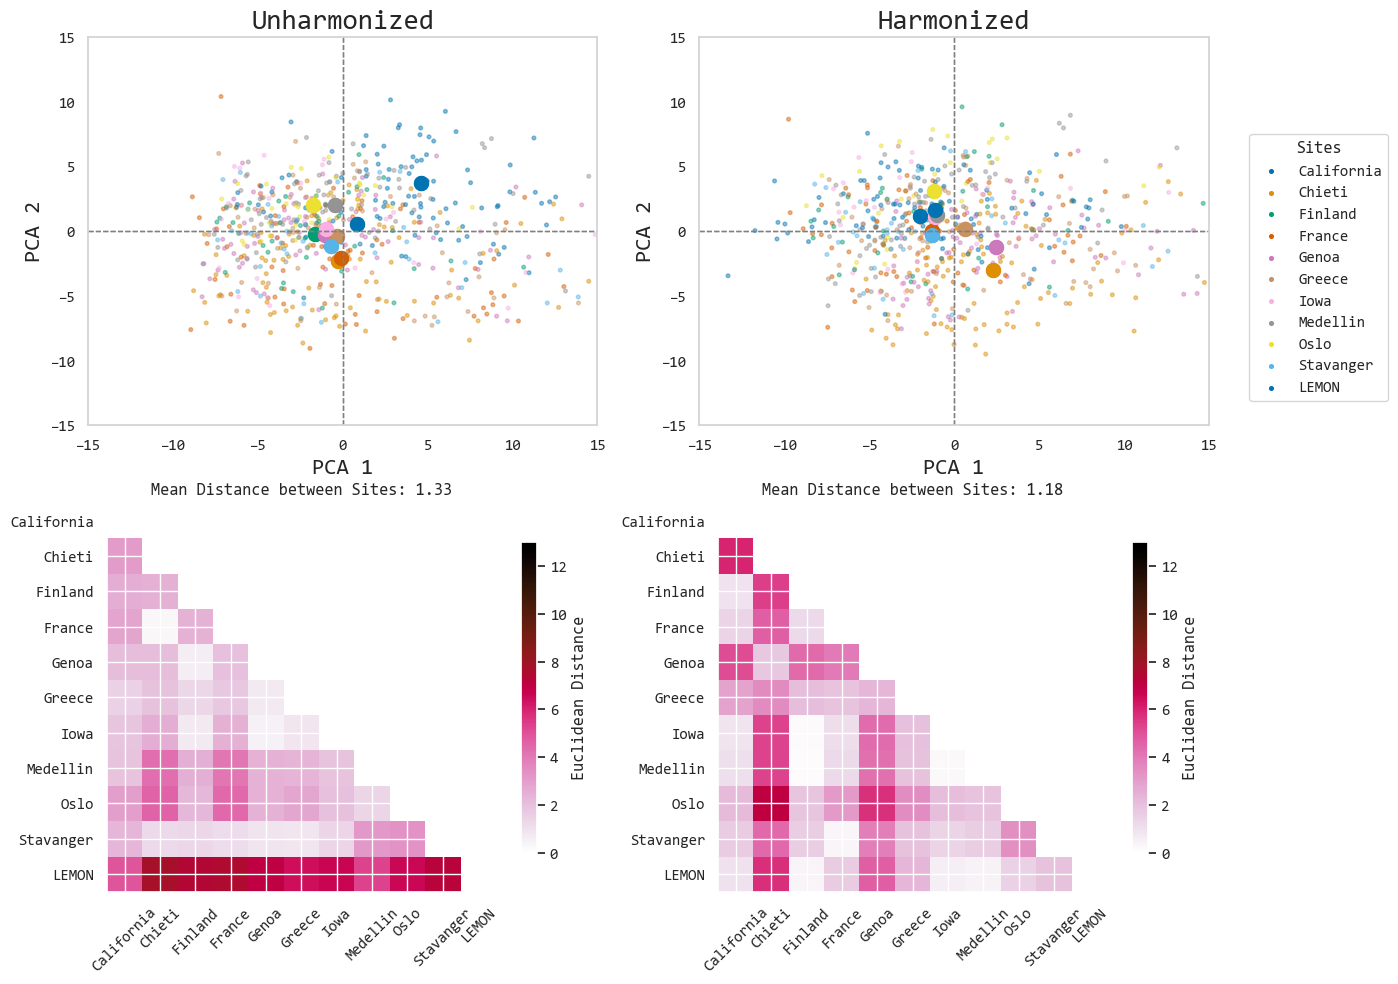

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt
# Set palette and labels
group_labels = {'california': 'California', 'chieti': 'Chieti', 'finland': 'Finland', 'france': 'France', 'genoa': 'Genoa', 'greece':'Greece', 'iowa': 'Iowa', 'medellin':'Medellin', 'oslo': 'Oslo', 'stavanger':'Stavanger','lemon': 'LEMON'}#'lemon': 'LEMON',

sns.set_style('white')
sns.set(font="Consolas")

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each center
X_unharmonized = wide.loc[:, ~wide.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = wide['center'].values

X_neurocombat = all_combat_df.loc[:, ~all_combat_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group', 'split'])].values
labels_neurocombat = all_combat_df['center'].values


palette = sns.color_palette('colorblind', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2, random_state=42)
X_pca_unharmonized = pca.fit_transform(X_unharmonized)
X_pca_neurocombat = pca.fit_transform(X_neurocombat)

# Function to plot PCA results
def plot_pca(X_pca, labels, title, ax):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=7, c=[colors[label] for label in labels], alpha=0.25)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

    for group in group_labels:
        ax.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        center_point = X_pca[group_indices, :].mean(axis=0)
        ax.scatter(center_point[0], center_point[1], s=100, c=[colors[group]], marker='o')

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    ax.set_facecolor('white')
    ax.grid(False)


# Plot the PCA plots and the distance matrices
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', axs[0, 0])
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', axs[0, 1])

# Create a single legend for the first two subplots and place it to the right
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 0.85), facecolor='white', ncol=1, title = "Sites")

# Calculate the Euclidean distances between center points for PCA
center_points_pca_unharmonized = {}
center_points_pca_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    center_points_pca_unharmonized[group] = X_pca_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    center_points_pca_neurocombat[group] = X_pca_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_pca_unharmonized = euclidean_distances(list(center_points_pca_unharmonized.values()))
distances_pca_neurocombat = euclidean_distances(list(center_points_pca_neurocombat.values()))

distances_pca_unharmonized = np.tril(distances_pca_unharmonized, k=-1)
distances_pca_neurocombat = np.tril(distances_pca_neurocombat, k=-1)



ax1 = plt.subplot(221)
plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', ax1)

ax2 = plt.subplot(222)
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', ax2)

plt.subplot(223)
plt.imshow(distances_pca_unharmonized, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_pca_neurocombat, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))


plt.subplots_adjust(top=0.95, bottom=0.0001, left = 0.001, right=1.02)
plt.show()

plt.show();


## Joyplots

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd

def joyplot(data, variable, hue, quantile_colors, size, title="", x_label="", y_label=""):
    # Initialize the figure and get the Axes object
    sns.set(font="Consolas")

    fig, ax = plt.subplots(figsize=size)

    # The vertical offset for each subsequent plot
    offset = 0
    offsets = []

    # Get unique values of the hue variable for y-axis labels
    unique_values = data[hue].unique()

    # Loop over each category in the hue variable
    for category in unique_values:
        category_data = data[data[hue] == category]

        # Calculate the quantiles for each distribution
        q1 = np.percentile(category_data[variable], 25)
        q2 = np.percentile(category_data[variable], 50)
        q3 = np.percentile(category_data[variable], 75)
        q4 = np.percentile(category_data[variable], 100)
        sns.set(font='Consolas')
        sns.set_style(rc={'axes.facecolor': 'white'})

        # Create a KDE plot for the data
        kde = sns.kdeplot(category_data[variable], color='grey', alpha=0.5, bw_adjust=0.5, ax=ax)

        # Get the line data from the plot
        kde_x, kde_y = kde.lines[-1].get_data()
        kde_y += offset  # Offset the y-values by the current offset

        # Plot the filled quantiles
        ax.fill_between(kde_x, offset, kde_y, where=(kde_x <= q1), color=quantile_colors[0], alpha=0.5)
        ax.fill_between(kde_x, offset, kde_y, where=(kde_x > q1) & (kde_x <= q2), color=quantile_colors[1], alpha=0.5)
        ax.fill_between(kde_x, offset, kde_y, where=(kde_x > q2) & (kde_x <= q3), color=quantile_colors[2], alpha=0.5)
        ax.fill_between(kde_x, offset, kde_y, where=(kde_x > q3), color=quantile_colors[3], alpha=0.5)
        offsets.append(offset)

        # Increment the offset for the next plot
        offset += (kde_y.max() - kde_y.min())

        # Remove the original line
        kde.lines[-1].remove()

    # Set the title, and x and y labels of the plot
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel(x_label if x_label else str(variable).upper(), fontweight='bold')
    ax.set_ylabel(y_label if y_label else str(hue).upper(), fontweight='bold')

    # Set y-ticks as labels from the unique values of the hue variable in uppercase
    ax.set_yticks(offsets)
    ax.set_yticklabels([str(value).capitalize() for value in unique_values], fontweight='bold')
    ax.set_facecolor('white')
    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide the grid
    ax.grid(False)

    # Show the plot
    plt.show()


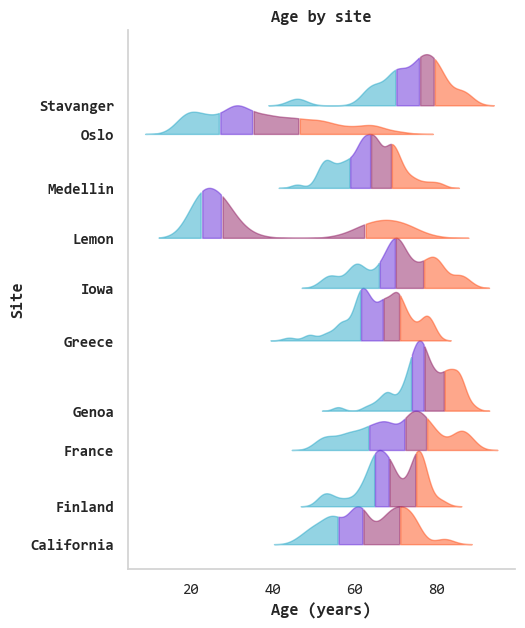

In [ ]:
# Define the colors for each quantile
import cmasher as cmr

quantile_colors = cmr.take_cmap_colors('cmr.guppy_r', N=4, cmap_range=(0.1, 0.9), return_fmt='hex')

# Call the joyplot function
joyplot(unharmonized, 'age', 'center', quantile_colors, size = (5,7), title="Age by site", x_label="Age (years)", y_label="Site")

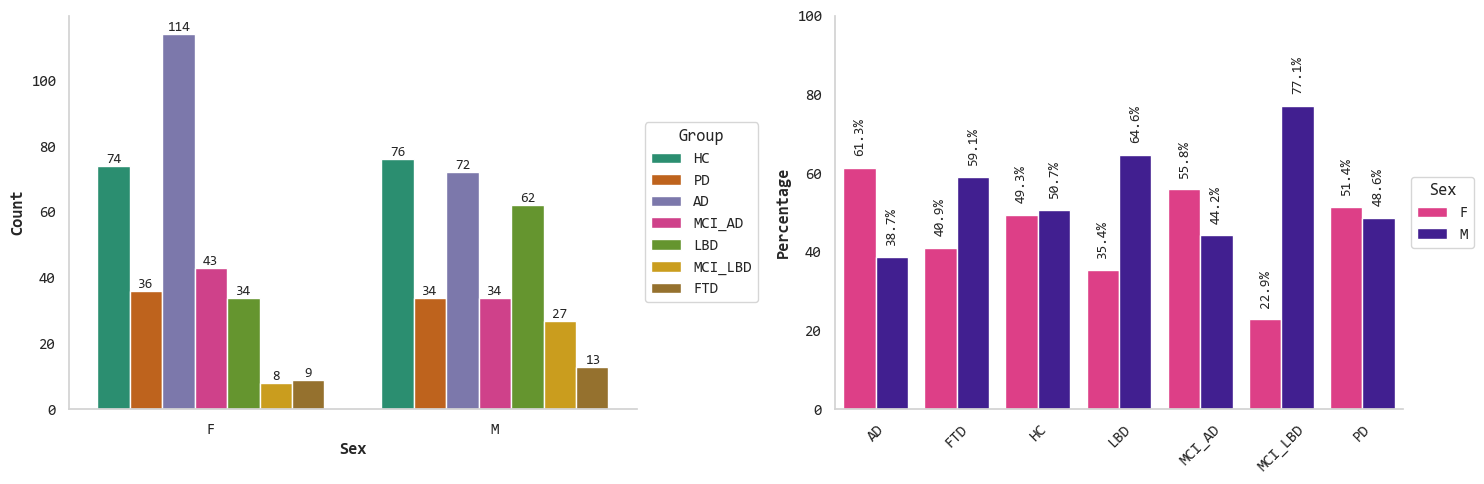

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style('white')
sns.set(font="Consolas")

# Read the dataset
# Sorting the DataFrame by participant_id and any other necessary columns
features_filtered = features_filtered.sort_values(by=['participant_id'])

# Keeping only the first row for each unique participant_id
df = features_filtered.drop_duplicates(subset='participant_id', keep='first')

palette = 'Dark2'

# Create a 1x2 grid layout
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, figure=fig)

# First subplot
ax1 = fig.add_subplot(gs[0, 0])

sns.countplot(x="gender", hue="group", data=df, palette=palette, ax=ax1)

ax1.set_title("")
ax1.set_xlabel("Sex", fontweight='bold')
ax1.set_ylabel("Count", fontweight='bold')
ax1.set_xticklabels([tick.get_text().upper() for tick in ax1.get_xticklabels()])
ax1.set_facecolor('white')


# Set spines color
for spine in ax1.spines.values():
    spine.set_edgecolor('lightgray')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', size=10)

# Move the legend outside
legend1 = ax1.legend(title='Group', bbox_to_anchor=(1, 0.5), loc='center left', facecolor='white')
# Capitalize legend items
for text in legend1.get_texts():
    text.set_text(text.get_text().upper())


palette = ["#F72585", "#3A0CA3"]# "#7209B7",

# Second subplot
ax2 = fig.add_subplot(gs[0, 1])

counts = df.groupby(['group', 'gender']).size().reset_index(name='count')
total_counts = counts.groupby('group')['count'].transform('sum')
counts['percentage'] = counts['count'] / total_counts * 100

sns.barplot(x='group', y='percentage', hue='gender', data=counts, palette=palette, ax=ax2)

ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("Percentage", fontweight='bold')
ax2.set_ylim(0, 100)
legend2 = ax2.legend(title='Sex', bbox_to_anchor=(1, 0.5), loc='center left', facecolor='white')
# Capitalize legend items
for text in legend2.get_texts():
    text.set_text(text.get_text().capitalize())

ax2.set_xticklabels([tick.get_text().upper() for tick in ax2.get_xticklabels()], rotation=45)

ax2.set_facecolor('white')


# Set spines color
for spine in ax2.spines.values():
    spine.set_edgecolor('lightgray')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height+3),
                ha='center', va='bottom', size=10, rotation=90)

# Adjust spacing between subplots
fig.tight_layout()

# Save the combined figure
plt.show()  # Or savefig('D:/data_analysis/papers_alberto/eeg_ndd_automl/figures/fig1b.tiff', format='tiff', dpi=300)


BATCH PCA

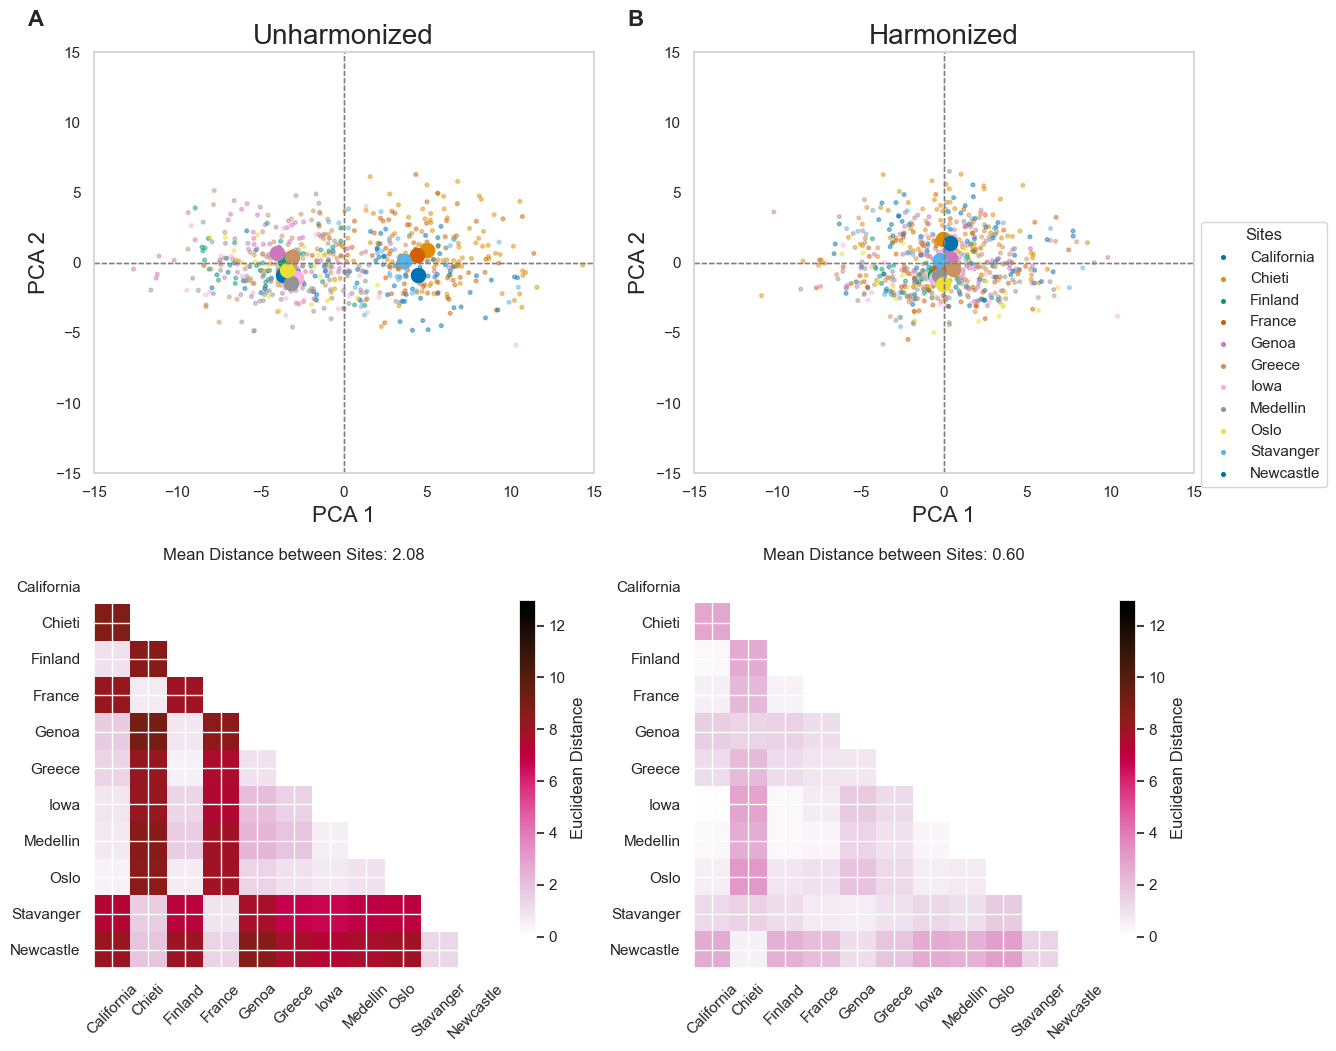

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt
# Set palette and labels
group_labels = {'california': 'California', 'chieti': 'Chieti', 'finland': 'Finland', 'france': 'France', 'genoa': 'Genoa', 'greece':'Greece', 'iowa': 'Iowa', 'medellin':'Medellin', 'oslo': 'Oslo', 'stavanger':'Stavanger', 'newcastle':'Newcastle'}#'lemon': 'LEMON',

sns.set_style('white')
sns.set(font='sans-serif')

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each center
X_unharmonized = pivoted_df.loc[:, ~pivoted_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = pivoted_df['center'].values

X_neurocombat = all_combat.loc[:, ~all_combat.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_neurocombat = all_combat['center'].values


palette = sns.color_palette('colorblind', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2, random_state=42)
X_pca_unharmonized = pca.fit_transform(X_unharmonized)
X_pca_neurocombat = pca.fit_transform(X_neurocombat)

# Function to plot PCA results
def plot_pca(X_pca, labels, title, ax):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=7, c=[colors[label] for label in labels], alpha=0.25)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

    for group in group_labels:
        ax.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        center_point = X_pca[group_indices, :].mean(axis=0)
        ax.scatter(center_point[0], center_point[1], s=100, c=[colors[group]], marker='o')

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    ax.set_facecolor('white')
    ax.grid(False)


# Plot the PCA plots and the distance matrices
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

# Annotations for each subplot
annotations = ['A', 'B', '', '']

plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', axs[0, 0])
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', axs[0, 1])

# Create a single legend for the first two subplots and place it to the right
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 0.85), facecolor='white', ncol=1, title = "Sites")

# Calculate the Euclidean distances between center points for PCA
center_points_pca_unharmonized = {}
center_points_pca_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    center_points_pca_unharmonized[group] = X_pca_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    center_points_pca_neurocombat[group] = X_pca_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_pca_unharmonized = euclidean_distances(list(center_points_pca_unharmonized.values()))
distances_pca_neurocombat = euclidean_distances(list(center_points_pca_neurocombat.values()))

distances_pca_unharmonized = np.tril(distances_pca_unharmonized, k=-1)
distances_pca_neurocombat = np.tril(distances_pca_neurocombat, k=-1)



ax1 = plt.subplot(221)
plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', ax1)

ax2 = plt.subplot(222)
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', ax2)

plt.subplot(223)
plt.imshow(distances_pca_unharmonized, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_pca_neurocombat, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))


# Add annotations and adjust subplots' layout
for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1, 1.1, annotations[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust the spacing of the subplots
plt.subplots_adjust(top=1.03, bottom=0.0005, left=0.05, right=1.05)



plt.show();


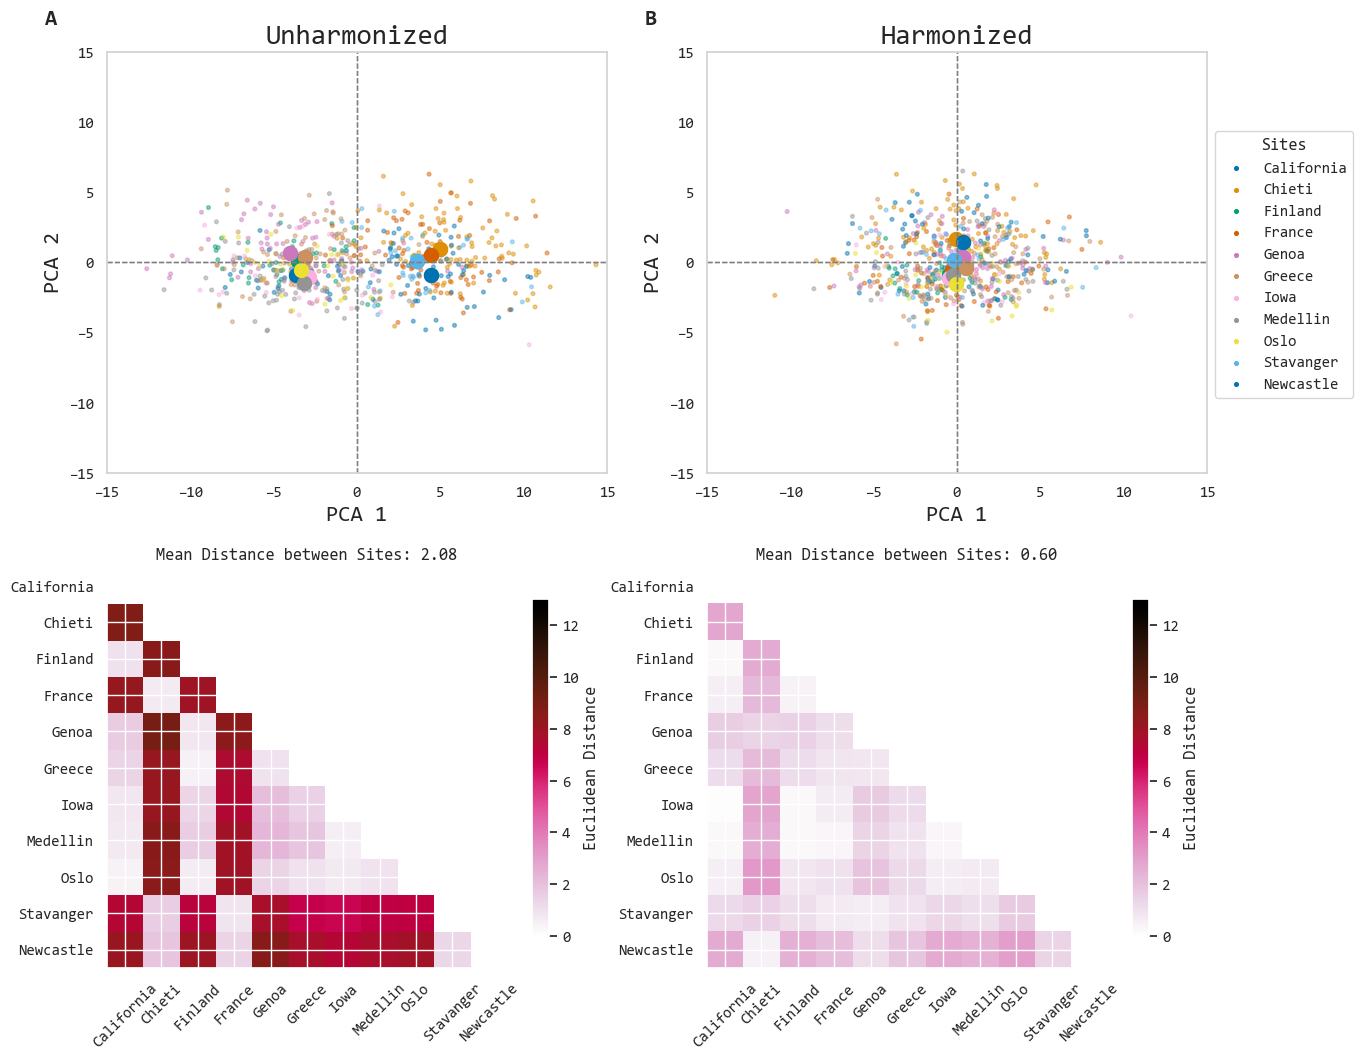

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt
# Set palette and labels
group_labels = {'california': 'California', 'chieti': 'Chieti', 'finland': 'Finland', 'france': 'France', 'genoa': 'Genoa', 'greece':'Greece', 'iowa': 'Iowa', 'medellin':'Medellin', 'oslo': 'Oslo', 'stavanger':'Stavanger', 'newcastle':'Newcastle'}#'lemon': 'LEMON',

sns.set_style('white')
sns.set(font="Consolas")

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each center
X_unharmonized = pivoted_df.loc[:, ~pivoted_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = pivoted_df['center'].values

X_neurocombat = all_combat.loc[:, ~all_combat.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_neurocombat = all_combat['center'].values


palette = sns.color_palette('colorblind', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2, random_state=42)
X_pca_unharmonized = pca.fit_transform(X_unharmonized)
X_pca_neurocombat = pca.fit_transform(X_neurocombat)

# Function to plot PCA results
def plot_pca(X_pca, labels, title, ax):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=7, c=[colors[label] for label in labels], alpha=0.25)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

    for group in group_labels:
        ax.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        center_point = X_pca[group_indices, :].mean(axis=0)
        ax.scatter(center_point[0], center_point[1], s=100, c=[colors[group]], marker='o')

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    ax.set_facecolor('white')
    ax.grid(False)


# Plot the PCA plots and the distance matrices
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', axs[0, 0])
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', axs[0, 1])

# Create a single legend for the first two subplots and place it to the right
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 0.95), facecolor='white', ncol=1, title = "Sites")

# Calculate the Euclidean distances between center points for PCA
center_points_pca_unharmonized = {}
center_points_pca_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    center_points_pca_unharmonized[group] = X_pca_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    center_points_pca_neurocombat[group] = X_pca_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_pca_unharmonized = euclidean_distances(list(center_points_pca_unharmonized.values()))
distances_pca_neurocombat = euclidean_distances(list(center_points_pca_neurocombat.values()))

distances_pca_unharmonized = np.tril(distances_pca_unharmonized, k=-1)
distances_pca_neurocombat = np.tril(distances_pca_neurocombat, k=-1)



ax1 = plt.subplot(221)
plot_pca(X_pca_unharmonized, labels_unharmonized, 'Unharmonized', ax1)

ax2 = plt.subplot(222)
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized', ax2)

plt.subplot(223)
plt.imshow(distances_pca_unharmonized, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_pca_neurocombat, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Distance between Sites: {:.2f}'.format(np.mean(distances_pca_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))


# Annotations for each subplot
annotations = ['A', 'B', '', '']

# Add annotations and adjust subplots' layout
for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1, 1.1, annotations[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust the spacing of the subplots
plt.subplots_adjust(top=1.03, bottom=0.0005, left=0.05, right=1.05)


plt.show();


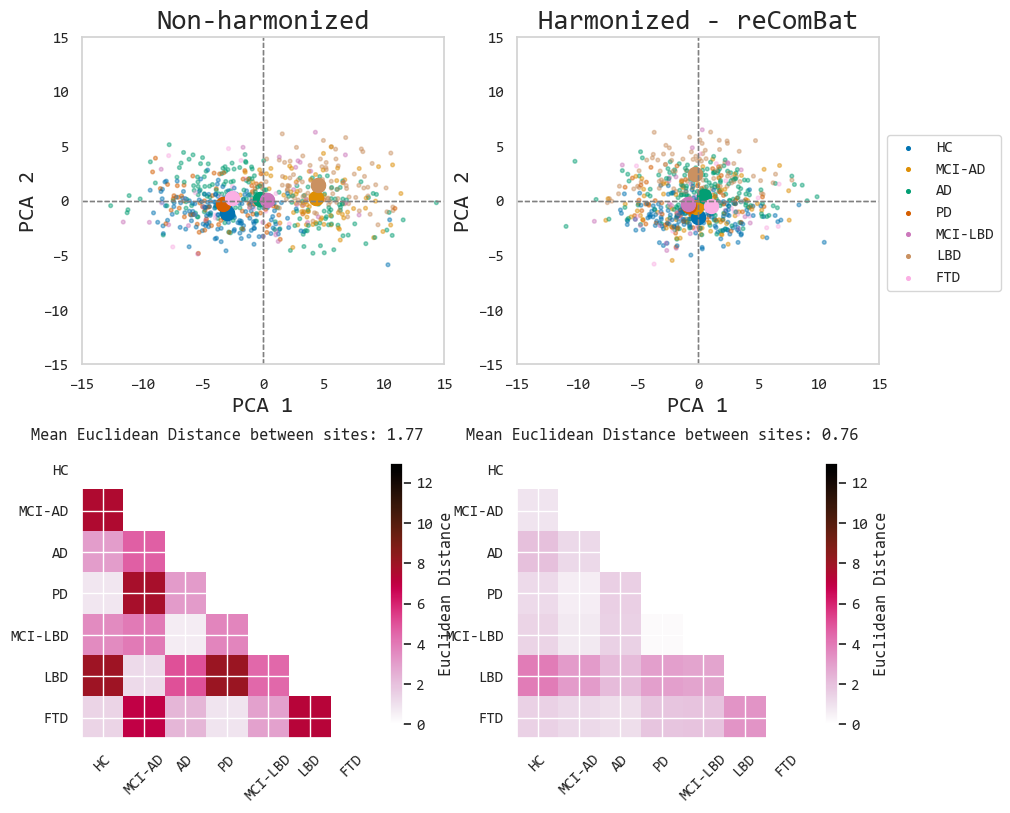

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
import numpy as np
import cmasher as cmr
import seaborn as sns
import matplotlib.pyplot as plt
group_labels = {'hc':'HC','mci_ad':'MCI-AD', 'ad':'AD', 'pd':'PD','mci_lbd':'MCI-LBD','lbd':'LBD', 'ftd':'FTD'}


sns.set_style('white')
sns.set(font="Consolas")

cmap_r = cmr.flamingo_r

# Read dataframes and get labels for each center
X_unharmonized = pivoted_df.loc[:, ~pivoted_df.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_unharmonized = pivoted_df['group'].values

X_neurocombat = all_combat.loc[:, ~all_combat.columns.isin(['participant_id', 'center', 'age', 'gender', 'group'])].values
labels_neurocombat = all_combat['group'].values


palette = sns.color_palette('colorblind', len(group_labels))
colors = {group: palette[i] for i, group in enumerate(group_labels)}
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2, random_state=42)
X_pca_unharmonized = pca.fit_transform(X_unharmonized)
X_pca_neurocombat = pca.fit_transform(X_neurocombat)

# Function to plot PCA results
def plot_pca(X_pca, labels, title, ax):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=7, c=[colors[label] for label in labels], alpha=0.25)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

    for group in group_labels:
        ax.scatter([], [], s=7, c=[colors[group]], label=group_labels[group])

    for group in group_labels:
        group_indices = np.where(labels == group)[0]
        center_point = X_pca[group_indices, :].mean(axis=0)
        ax.scatter(center_point[0], center_point[1], s=100, c=[colors[group]], marker='o')

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    ax.set_facecolor('white')
    ax.grid(False)


# Plot the PCA plots and the distance matrices
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

plot_pca(X_pca_unharmonized, labels_unharmonized, 'Non-harmonized', axs[0, 0])
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized - reComBat', axs[0, 1])

# Create a single legend for the first two subplots and place it to the right
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.85, 0.85), facecolor='white', ncol=1)

# Calculate the Euclidean distances between center points for PCA
center_points_pca_unharmonized = {}
center_points_pca_neurocombat = {}
for group in group_labels:
    group_indices_unharmonized = np.where(labels_unharmonized == group)[0]
    group_indices_neurocombat = np.where(labels_neurocombat == group)[0]
    center_points_pca_unharmonized[group] = X_pca_unharmonized[group_indices_unharmonized, :].mean(axis=0)
    center_points_pca_neurocombat[group] = X_pca_neurocombat[group_indices_neurocombat, :].mean(axis=0)

distances_pca_unharmonized = euclidean_distances(list(center_points_pca_unharmonized.values()))
distances_pca_neurocombat = euclidean_distances(list(center_points_pca_neurocombat.values()))

distances_pca_unharmonized = np.tril(distances_pca_unharmonized, k=-1)
distances_pca_neurocombat = np.tril(distances_pca_neurocombat, k=-1)



ax1 = plt.subplot(221)
plot_pca(X_pca_unharmonized, labels_unharmonized, 'Non-harmonized', ax1)

ax2 = plt.subplot(222)
plot_pca(X_pca_neurocombat, labels_neurocombat, 'Harmonized - reComBat', ax2)

plt.subplot(223)
plt.imshow(distances_pca_unharmonized, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_pca_unharmonized)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))

plt.subplot(224)
plt.imshow(distances_pca_neurocombat, cmap=cmap_r, vmax=13)
plt.colorbar(label='Euclidean Distance', shrink=0.8)
plt.title('Mean Euclidean Distance between sites: {:.2f}'.format(np.mean(distances_pca_neurocombat)))

plt.xticks(range(len(group_labels)), list(group_labels.values()), rotation=45)
plt.yticks(range(len(group_labels)), list(group_labels.values()))


plt.subplots_adjust(top=0.95, bottom=0.15, right=0.85)
plt.show()

plt.show();


Rearray to long format df

In [ ]:
import pandas as pd

# Assume you have a DataFrame called combat_psd
combat_psd = pd.melt(all_combat, id_vars=['participant_id', 'center', 'group', 'age', 'gender'],
                     value_vars=all_combat.columns[5:], var_name='frequency', value_name='psd')

# Remove "frequency" word and brackets from the frequency column
combat_psd['frequency'] = combat_psd['frequency'].str.replace('frequency[', '').str.rstrip(']')
# Round the frequency values to 1 decimal place
combat_psd['frequency'] = combat_psd['frequency'].astype(float).round(1)
# Sort the dataframe by participant_id
combat_psd = combat_psd.sort_values(by=['participant_id', 'frequency'])
# Reset the index
combat_psd = combat_psd.reset_index(drop=True)

# Print the final unpivoted dataframe
print(combat_psd)


      participant_id      center group   age gender  frequency        psd
0              c_hc1  california    hc  54.0      f        1.0  -9.262776
1              c_hc1  california    hc  54.0      f        1.2  -9.223074
2              c_hc1  california    hc  54.0      f        1.4  -9.207956
3              c_hc1  california    hc  54.0      f        1.6  -9.220279
4              c_hc1  california    hc  54.0      f        1.8  -9.245544
...              ...         ...   ...   ...    ...        ...        ...
92851    sta_D20171K   stavanger    hc  65.0      f       29.2 -11.116745
92852    sta_D20171K   stavanger    hc  65.0      f       29.4 -11.135124
92853    sta_D20171K   stavanger    hc  65.0      f       29.6 -11.128259
92854    sta_D20171K   stavanger    hc  65.0      f       29.8 -11.133267
92855    sta_D20171K   stavanger    hc  65.0      f       30.0 -11.124254

[92856 rows x 7 columns]


Joyplot harmonized

c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\data_analysis\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


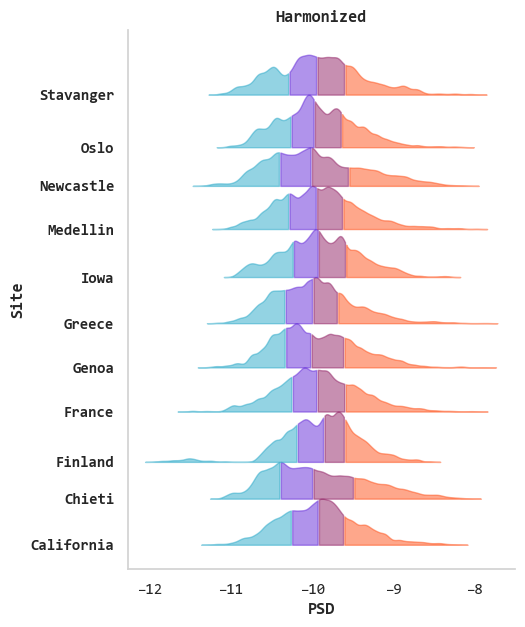

In [ ]:
# Define the colors for each quantile
import cmasher as cmr

quantile_colors = cmr.take_cmap_colors('cmr.guppy_r', N=4, cmap_range=(0.1, 0.9), return_fmt='hex')

# Call the joyplot function
joyplot(combat_psd, 'psd', 'center', quantile_colors, size = (5,7), title="Harmonized", x_label="PSD", y_label="Site")

Stacked histograms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


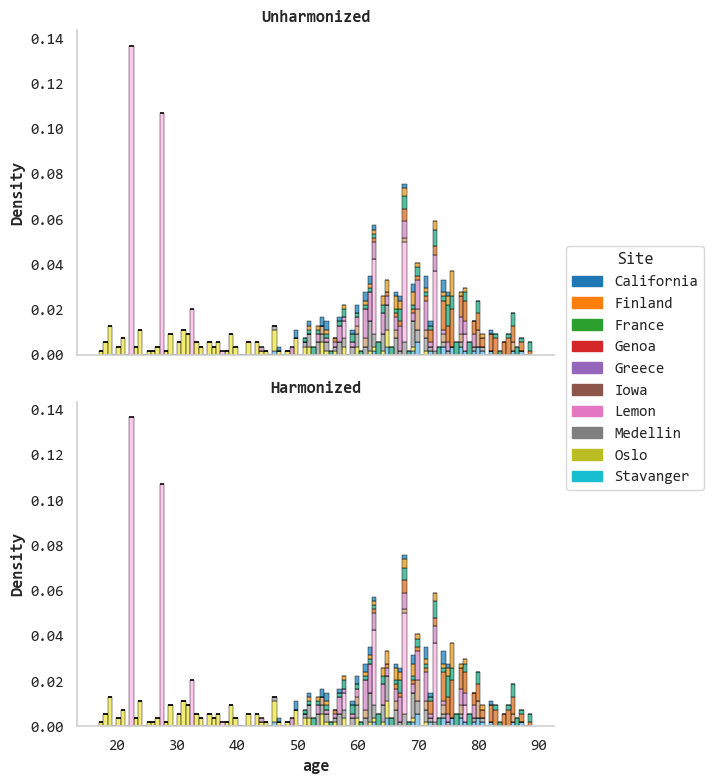

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `unharmonized` is the DataFrame we previously worked with and has been loaded with log10 transformed 'age' values
# First, let's capitalize the first letter of the 'center' entries for the legend labels
unharmonized['center'] = unharmonized['center'].str.capitalize()

sns.set(font="Consolas")

# Now create the subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True, sharey = True)

# First subplot without hue
sns.histplot(data=unharmonized, x='age', hue="center", element="bars", multiple='stack', fill=True, ax=axes[0], alpha = 0.666, palette="colorblind", bins=100, stat='density', edgecolor="black")
axes[0].set_title('Unharmonized', fontweight='bold')
axes[0].set_xlabel('age', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].set_facecolor('white')  # Set the background color
axes[0].legend(handles=None, labels=None, title='', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
axes[0].grid(False)  # Turn off the grid
# Set spines color
for spine in axes[0].spines.values():
    spine.set_edgecolor('lightgray')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)



# Second subplot with hue by 'center'
sns.histplot(data=unharmonized, x='age', hue="center", element="bars",
             multiple='stack', fill=True, ax=axes[1], alpha = 0.666, palette="colorblind", bins=100, stat='density', edgecolor="black")
axes[1].set_title('Harmonized', fontweight='bold')
axes[1].set_xlabel('age', fontweight='bold')
axes[1].set_ylabel('Density', fontweight='bold')
axes[1].set_facecolor('white')  # Set the background color
axes[1].grid(False)  # Turn off the grid
axes[1].legend(handles=None, labels=None, title='', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Set spines color
for spine in axes[1].spines.values():
    spine.set_edgecolor('lightgray')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

# Creating custom handles for the legend
centers = unharmonized['center'].unique()
palette = sns.color_palette("tab10", len(centers))
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(centers))]
labels = centers.tolist()  # Ensure labels are a list

# Creating custom legend
fig.legend(handles=handles, labels=labels, title='Site', loc='right', bbox_to_anchor=(1.2, 0.53) , facecolor='white',  frameon=True, ncol=1)

plt.tight_layout()
plt.show()




# Pairwise comparisons of spectrum (osc, aperiodic, or full spectrum)

In [ ]:
bandpowers_file.to_feather('D:/data_analysis/papers_alberto/final_phd/derivatives_data/all_psd_vectors.feather')

Here I import long-format data with the spectral values from FOOOF (psd_fit, osc_fit, ap_fit, plus osc and ap which are the reconstructed oscillatory and aperiodic components, each value is indexed in a given frequency for each channel)

In [ ]:
import pandas as pd

path = 'D:/data_analysis/papers_alberto/final_phd/derivatives_data/all_psd_vectors.feather'
bandpowers_file = pd.read_feather(path)
bandpowers_file.head(50)



participant_id group   age gender channel  r_squared        psd  center  \
0         chi_078   dlb  77.0      m      P7   0.994687 -11.230047  chieti   
1         chi_078   dlb  77.0      m      P7   0.994687 -11.197747  chieti   
2         chi_078   dlb  77.0      m      P7   0.994687 -11.197308  chieti   
3         chi_078   dlb  77.0      m      P7   0.994687 -11.165276  chieti   
4         chi_078   dlb  77.0      m      P7   0.994687 -11.150414  chieti   
5         chi_078   dlb  77.0      m      P7   0.994687 -11.098567  chieti   
6         chi_078   dlb  77.0      m      P7   0.994687 -11.072492  chieti   
7         chi_078   dlb  77.0      m      P7   0.994687 -11.067194  chieti   
8         chi_078   dlb  77.0      m      P7   0.994687 -11.035723  chieti   
9         chi_078   dlb  77.0      m      P7   0.994687 -11.014292  chieti   
10        chi_078   dlb  77.0      m      P7   0.994687 -10.974158  chieti   
11        chi_078   dlb  77.0      m      P7   0.994687 -10.948886  chieti   
12        chi_078   dlb  77.0      m      P7   0.994687 -10.945612  chieti   
13        chi_078   dlb  77.0      m      P7   0.994687 -10.943115  chieti   
14        chi_078   dlb  77.0      m      P7   0.994687 -10.937089  chieti   
15        chi_078   dlb  77.0      m      P7   0.994687 -10.906073  chieti   
16        chi_078   dlb  77.0      m      P7   0.994687 -10.896721  chieti   
17        chi_078   dlb  77.0      m      P7   0.994687 -10.894376  chieti   
18        chi_078   dlb  77.0      m      P7   0.994687 -10.890191  chieti   
19        chi_078   dlb  77.0      m      P7   0.994687 -10.890134  chieti   
20        chi_078   dlb  77.0      m      P7   0.994687 -10.887631  chieti   
21        chi_078   dlb  77.0      m      P7   0.994687 -10.873800  chieti   
22        chi_078   dlb  77.0      m      P7   0.994687 -10.864403  chieti   
23        chi_078   dlb  77.0      m      P7   0.994687 -10.853155  chieti   
24        chi_078   dlb  77.0      m      P7   0.994687 -10.848275  chieti   
25        chi_078   dlb  77.0      m      P7   0.994687 -10.847166  chieti   
26        chi_078   dlb  77.0      m      P7   0.994687 -10.840828  chieti   
27        chi_078   dlb  77.0      m      P7   0.994687 -10.840493  chieti   
28        chi_078   dlb  77.0      m      P7   0.994687 -10.840213  chieti   
29        chi_078   dlb  77.0      m      P7   0.994687 -10.826216  chieti   
30        chi_078   dlb  77.0      m      P7   0.994687 -10.818239  chieti   
31        chi_078   dlb  77.0      m      P7   0.994687 -10.817044  chieti   
32        chi_078   dlb  77.0      m      P7   0.994687 -10.816001  chieti   
33        chi_078   dlb  77.0      m      P7   0.994687 -10.814432  chieti   
34        chi_078   dlb  77.0      m      P7   0.994687 -10.782111  chieti   
35        chi_078   dlb  77.0      m      P7   0.994687 -10.779593  chieti   
36        chi_078   dlb  77.0      m      P7   0.994687 -10.770646  chieti   
37        chi_078   dlb  77.0      m      P7   0.994687 -10.764992  chieti   
38        chi_078   dlb  77.0      m      P7   0.994687 -10.759288  chieti   
39        chi_078   dlb  77.0      m      P7   0.994687 -10.758574  chieti   
40        chi_078   dlb  77.0      m      P7   0.994687 -10.745237  chieti   
41        chi_078   dlb  77.0      m      P7   0.994687 -10.721510  chieti   
42        chi_078   dlb  77.0      m      P7   0.994687 -10.682359  chieti   
43        chi_078   dlb  77.0      m      P7   0.994687 -10.680156  chieti   
44        chi_078   dlb  77.0      m      P7   0.994687 -10.634457  chieti   
45        chi_078   dlb  77.0      m      P7   0.994687 -10.601933  chieti   
46        chi_078   dlb  77.0      m      P7   0.994687 -10.565048  chieti   
47        chi_078   dlb  77.0      m      P7   0.994687 -10.562555  chieti   
48        chi_078   dlb  77.0      m      P7   0.994687 -10.552055  chieti   
49        chi_078   dlb  77.0      m      P7   0.994687 -10.542595  chieti   

    frequency    psd_fit

Aggregate MCI-LBD and LBD groups
Drop LEMON

In [ ]:

# List of groups to exclude
excluded_values = ['sci']  # 5 subjects with Subjective cognitive impairment & FTD group

# Filter the dataset to exclude rows where 'group' is in the excluded values list
bandpowers_file = bandpowers_file[(~bandpowers_file['group'].isin(excluded_values)) & (bandpowers_file['age'] >= 46)].reset_index(drop=True)

# posterior_roi = ["P3", "P4", "P7", "P8", "Pz", "PO3", "PO4", "Oz", "O1", "O2"]

# # Filter the dataset to exclude rows where 'group' is in the excluded values list
# bandpowers_file = bandpowers_file[(bandpowers_file['channel'].isin(posterior_roi))].reset_index(drop=True)


# Now, you can proceed with merging "PD-MCI" and "DLB-MCI" as you did in your example
bandpowers_file['group'] = bandpowers_file['group'].replace({'mci_lb': 'mci_lbd', 'pd_mci': 'mci_lbd'})

bandpowers_file['group'] = bandpowers_file['group'].replace({'dlb': 'lbd', 'pdd': 'lbd'})
bandpowers_file = bandpowers_file[bandpowers_file['center'] != 'lemon']


Here I collapsed all channels by getting the median. Below I set "psd" to reshape data ONLY from the full psd spectrum

In [ ]:
#bandpowers_file = bandpowers_file[bandpowers_file['center'] != 'lemon']

# Calculate the median psd values across channels per participant
median_psd = bandpowers_file.groupby(['participant_id', 'center', 'group', 'age', 'gender', 'frequency'])['psd'].median().reset_index()

# Pivot the dataframe
pivoted_df = median_psd.pivot(index=['participant_id', 'center', 'group', 'age', 'gender'], columns='frequency', values='psd').reset_index()

# Rename the frequency columns
pivoted_df.columns = ['participant_id', 'center', 'group', 'age', 'gender'] + ['{}'.format(col) for col in pivoted_df.columns[5:]]



Here each frequency bin is a column

In [ ]:
pivoted_df

participant_id      center   group   age gender        1.0  \
0            c_hc1  california      hc  54.0      f  -9.010123   
1           c_hc10  california      hc  59.0      f  -9.000371   
2           c_hc18  california      hc  57.0      m  -9.299848   
3            c_hc2  california      hc  50.0      f  -9.248021   
4           c_hc20  california      hc  68.0      m  -9.140897   
..             ...         ...     ...   ...    ...        ...   
631     sta_D20167   stavanger  mci_ad  74.0      m  -9.238961   
632     sta_D20168   stavanger  mci_ad  70.0      f  -9.675921   
633     sta_D20169   stavanger  mci_ad  72.0      m  -9.551655   
634     sta_D20170   stavanger  mci_ad  76.0      f  -9.539571   
635    sta_D20171K   stavanger      hc  65.0      f -10.174704   

     1.2000000000000002  1.4000000000000001        1.6        1.8  ...  \
0             -8.967919           -8.949833  -9.015330  -9.068488  ...   
1             -8.941203           -8.970201  -9.020352  -9.101820  ...   
2             -9.259207           -9.269094  -9.326513  -9.429628  ...   
3             -9.220313           -9.212376  -9.259367  -9.333134  ...   
4             -9.106232           -9.097458  -9.132093  -9.165924  ...   
..                  ...                 ...        ...        ...  ...   
631           -9.239836           -9.228118  -9.259390  -9.316229  ...   
632           -9.640287           -9.671377  -9.682521  -9.798791  ...   
633           -9.539130           -9.529131  -9.569005  -9.668463  ...   
634           -9.541411           -9.514712  -9.560055  -9.639041  ...   
635          -10.142807          -10.133390 -10.168160 -10.250948  ...   

     28.200000000000003  28.400000000000002       28.6       28.8       29.0  \
0             -9.789703           -9.812194  -9.848420  -9.846739  -9.868959   
1             -9.732240           -9.757948  -9.757734  -9.776569  -9.819564   
2            -10.571848          -10.608802 -10.600357 -10.627322 -10.611304   
3            -10.306332          -10.292239 -10.307189 -10.341865 -10.342621   
4            -10.079271          -10.062527 -10.113211 -10.111927 -10.106762   
..                  ...                 ...        ...        ...        ...   
631          -10.876583          -10.872060 -10.889032 -10.905700 -10.902270   
632          -10.835293          -10.869166 -10.875111 -10.889647 -10.857254   
633          -10.927394          -10.931414 -10.912310 -10.916418 -10.965757   
634          -10.949349          -10.970881 -10.973267 -10.997712 -10.968713   
635          -11.287925          -11.275040 -11.271751 -11.288664 -11.313729   

     29.200000000000003  29.400000000000002       29.6       29.8       30.0  
0             -9.868541           -9.871114  -9.872689  -9.875356  -9.886861  
1             -9.836277           -9.824384  -9.813606  -9.834690  -9.870767  
2            -10.633009          -10.644257 -10.647263 -10.679308 -10.654449  
3            -10.336865          -10.359679 -10.388050 -10.386304 -10.396278  
4            -10.091307          -10.088023 -10.098262 -10.067717 -10.093886  
..                  ...                 ...        ...        ...        ...  
631          -10.903189          -10.915511 -10.907631 -10.911273 -10.890934  
632          -10.871522          -10.873425 -10.857148 -10.851398 -10.871472  
633          -11.001154          -11.021961 -10.996781 -10.993401 -10.987570  
634          -10.978943          -11.014142 -11.019589 -11.052422 -11.087419  
635          -11.312963          -11.332560 -11.331462 -11.339185 -11.334372  

[636 rows x 151 columns]

Here the same orientation as the input long dataset but here is only for the median vector (not per channel)

In [ ]:
import pandas as pd

# Assume you have a DataFrame called unharm_psd
unharm_psd = pd.melt(pivoted_df, id_vars=['participant_id', 'center', 'group', 'age', 'gender'],
                     value_vars=pivoted_df.columns[5:], var_name='frequency', value_name='psd')

# Remove "frequency" word and brackets from the frequency column
#unharm_psd['frequency'] = unharm_psd['frequency'].str.replace('[', '').str.replace(']', '')
# Round the frequency values to 1 decimal place
unharm_psd['frequency'] = unharm_psd['frequency'].astype(float).round(1)
# Sort the dataframe by participant_id
unharm_psd = unharm_psd.sort_values(by=['participant_id', 'frequency'])
# Reset the index
unharm_psd = unharm_psd.reset_index(drop=True)
unharm_psd


participant_id      center group   age gender  frequency        psd
0              c_hc1  california    hc  54.0      f        1.0  -9.010123
1              c_hc1  california    hc  54.0      f        1.2  -8.967919
2              c_hc1  california    hc  54.0      f        1.4  -8.949833
3              c_hc1  california    hc  54.0      f        1.6  -9.015330
4              c_hc1  california    hc  54.0      f        1.8  -9.068488
...              ...         ...   ...   ...    ...        ...        ...
92851    sta_D20171K   stavanger    hc  65.0      f       29.2 -11.312963
92852    sta_D20171K   stavanger    hc  65.0      f       29.4 -11.332560
92853    sta_D20171K   stavanger    hc  65.0      f       29.6 -11.331462
92854    sta_D20171K   stavanger    hc  65.0      f       29.8 -11.339185
92855    sta_D20171K   stavanger    hc  65.0      f       30.0 -11.334372

[92856 rows x 7 columns]

GROUP DIFFERENCES PLOT WITH TICKS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.ticker as ticker
import numpy as np

def permutation_test(x, y, n_permutations=1000):
    """ Perform a permutation test to compute the p-value """
    observed_diff = np.abs(np.mean(x) - np.mean(y))
    combined = np.concatenate([x, y])
    count = 0

    for _ in range(n_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        new_diff = np.abs(np.mean(new_x) - np.mean(new_y))
        count += (new_diff >= observed_diff)

    p_value = count / n_permutations
    return p_value

def plot_group_diffs(df, plot='psd', fig_title = ''):
    group_categories = df['group'].unique()
    pairwise_comparisons = set()  # Use a set to keep track of unique comparisons

    # Determine the grid layout based on the number of pairwise comparisons
    num_pairs = 0
    num_cols = 3  # Fixed number of columns for each row
    num_rows = 0

    for group1 in group_categories:
        for group2 in group_categories:
            if group1 != group2 and (group1, group2) not in pairwise_comparisons and (group2, group1) not in pairwise_comparisons:
                pairwise_comparisons.add((group1, group2))
                num_pairs += 1

    # Calculate the number of rows needed based on the number of pairs
    num_rows = -(-num_pairs // num_cols)  # Ceiling division to calculate rows needed

    fig, axs = plt.subplots(figsize=(9, num_rows * 2.5), ncols=num_cols, nrows=num_rows)
    axs = axs.flatten()  # Flatten the subplots array to handle varying number of groups

    plt.rcParams['font.family'] = 'Consolas'
    sns.set(font="Consolas")

    # Create a color map from Seaborn palette
    palette = sns.color_palette("tab10", len(group_categories))
    color_map = dict(zip(group_categories, palette))

    for i, (group1, group2) in enumerate(pairwise_comparisons, start=1):
        ax = axs[i-1]  # Index is zero-based

        group1_data = df[df['group'] == group1][plot]
        group2_data = df[df['group'] == group2][plot]

        mean_group1 = group1_data.groupby(df['frequency']).mean()
        mean_group2 = group2_data.groupby(df['frequency']).mean()

        sem_group1 = group1_data.groupby(df['frequency']).sem()
        sem_group2 = group2_data.groupby(df['frequency']).sem()


        # Calculate p-values for each frequency point using permutation test
        p_vals = []
        for freq in mean_group1.index:
            group1_freq_data = group1_data[df['frequency'] == freq]
            group2_freq_data = group2_data[df['frequency'] == freq]
            p_value = permutation_test(group1_freq_data, group2_freq_data, n_permutations=1000)
            p_vals.append(p_value)

        # Correct p-values using fdr_by multiple testing correction
        _, p_vals_corrected, _, _ = multipletests(p_vals, method='fdr_by', alpha = 0.01)

        group1_color = color_map[group1]
        group2_color = color_map[group2]

        ax.plot(mean_group1.index, mean_group1.values, linewidth=2, label=group1.upper(), color=group1_color)
        ax.plot(mean_group2.index, mean_group2.values, linewidth=2, label=group2.upper(), color=group2_color)

        # Shade SEM for each group
        ax.fill_between(mean_group1.index, mean_group1 - 1.96 * sem_group1, mean_group1 + 1.96 * sem_group1, alpha=0.2, color=group1_color)
        ax.fill_between(mean_group2.index, mean_group2 - 1.96 * sem_group2, mean_group2 + 1.96 * sem_group2, alpha=0.2, color=group2_color)

        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (μV$^2$)')
        ax.xaxis.set_minor_locator(ticker.FixedLocator([5, 15, 25]))
        ax.tick_params(direction="out", which='both', bottom=True, color='k', length=6)
        if plot == 'osc_fit':
            ax.set_ylim(-0.16, 1.2)
            # Mask areas where p-value < 0.01 after correction with gray color
            for j in range(len(p_vals_corrected)):
                if p_vals_corrected[j] < 0.01:
                    ax.fill_between([mean_group1.index[j]], -0.19, -0.06, alpha=0.3, color='gray')
        else:
            ax.set_ylim(-11.0, -8.5)
            # Mask areas where p-value < 0.01 after correction with gray color
            for j in range(len(p_vals_corrected)):
                if p_vals_corrected[j] < 0.01:
                    ax.fill_between([mean_group1.index[j]], -11.02, -10.82, alpha=0.3, color='gray')

        ax.set_title(' ', size = 20)#f'{group1.upper()} vs {group2.upper()}')
        ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.52, 1.1), frameon=False, fontsize=9)
        # Set the spines to only show the bottom and left axis
        ax.grid(False)  # Turn off the grid
        ax.set_facecolor('white')
        # Set spines color
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    # Hide empty subplots
    for i in range(num_pairs, num_cols * num_rows):
        fig.delaxes(axs[i])


    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the rect parameter as needed
    plt.suptitle(fig_title, size=20)
    plt.show()



The function computes point-wise permutation t-tests and correct the p-vals using FDR BY (significant results are marked in the bottom of X axis as small lines)

By default this compares the spectrum using the "group" variable with the diagnosis, but just change "group" for sex or site

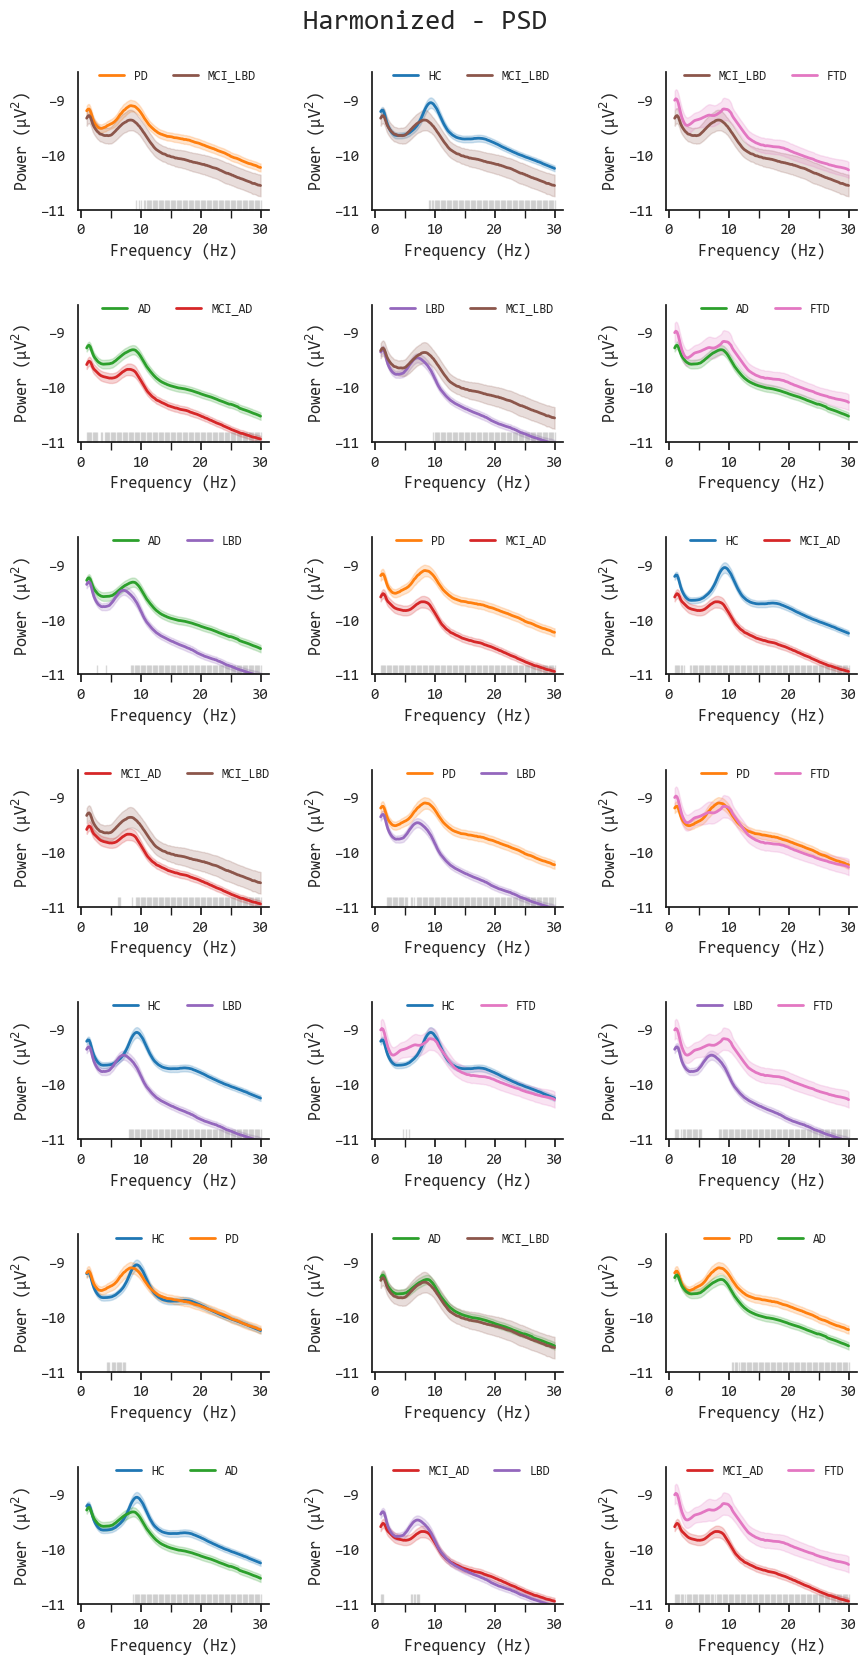

In [ ]:
# Example usage with a custom plot parameter
plot_group_diffs(unharm_psd, plot='psd', fig_title='Harmonized - PSD')


Same function but without permutation

In [ ]:
# ### NO PERMUTATION
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import ttest_ind
# from statsmodels.stats.multitest import multipletests
# import matplotlib.ticker as ticker


# def plot_group_diffs(df, plot='psd', fig_title=''):
#     group_categories = df['group'].unique()
#     pairwise_comparisons = set()  # Use a set to keep track of unique comparisons

#     # Determine the grid layout based on the number of pairwise comparisons
#     num_pairs = 0
#     num_cols = 3  # Fixed number of columns for each row
#     num_rows = 0

#     for group1 in group_categories:
#         for group2 in group_categories:
#             if group1 != group2 and (group1, group2) not in pairwise_comparisons and (group2, group1) not in pairwise_comparisons:
#                 pairwise_comparisons.add((group1, group2))
#                 num_pairs += 1

#     # Calculate the number of rows needed based on the number of pairs
#     num_rows = -(-num_pairs // num_cols)  # Ceiling division to calculate rows needed

#     fig, axs = plt.subplots(figsize=(9, num_rows * 2.5), ncols=num_cols, nrows=num_rows)
#     axs = axs.flatten()  # Flatten the subplots array to handle varying number of groups

#     plt.rcParams['font.family'] = 'Consolas'
#     sns.set(font="Consolas")

#     # Create a color map from Seaborn palette
#     palette = sns.color_palette("tab10", len(group_categories))
#     color_map = dict(zip(group_categories, palette))

#     for i, (group1, group2) in enumerate(pairwise_comparisons, start=1):
#         ax = axs[i-1]  # Index is zero-based

#         group1_data = df[df['group'] == group1][plot]
#         group2_data = df[df['group'] == group2][plot]

#         mean_group1 = group1_data.groupby(df['frequency']).mean()
#         mean_group2 = group2_data.groupby(df['frequency']).mean()

#         sem_group1 = group1_data.groupby(df['frequency']).sem()
#         sem_group2 = group2_data.groupby(df['frequency']).sem()


#         # Calculate p-values for each frequency point
#         p_vals = []
#         for freq in mean_group1.index:
#             p_value = ttest_ind(group1_data[df['frequency'] == freq], group2_data[df['frequency'] == freq])[1]
#             p_vals.append(p_value)

#         # Correct p-values using fdr_by multiple testing correction
#         _, p_vals_corrected, _, _ = multipletests(p_vals, method='fdr_by', alpha = 0.01)

#         group1_color = color_map[group1]
#         group2_color = color_map[group2]

#         ax.plot(mean_group1.index, mean_group1.values, linewidth=2, label=group1.upper(), color=group1_color)
#         ax.plot(mean_group2.index, mean_group2.values, linewidth=2, label=group2.upper(), color=group2_color)

#         # Shade SEM for each group
#         ax.fill_between(mean_group1.index, mean_group1 - 1.96 * sem_group1, mean_group1 + 1.96 * sem_group1, alpha=0.2, color=group1_color)
#         ax.fill_between(mean_group2.index, mean_group2 - 1.96 * sem_group2, mean_group2 + 1.96 * sem_group2, alpha=0.2, color=group2_color)


#         # Mask areas where p-value < 0.05 after correction with gray color
#         for j in range(len(p_vals_corrected)):
#             if p_vals_corrected[j] < 0.01:
#                 ax.fill_between([mean_group1.index[j]], -11.02, -10.82, alpha=0.3, color='gray')

#         ax.set_xlabel('Frequency (Hz)')
#         ax.set_ylabel('Power (μV$^2$)')
#         ax.xaxis.set_minor_locator(ticker.FixedLocator([5, 15, 25]))
#         ax.tick_params(direction="out", which='both', bottom=True, color='k', length=6)
#         if plot == 'osc_fit':
#             ax.set_ylim(-0.05, 1.5)
#         else:
#             ax.set_ylim(-11.0, -8)
#         ax.set_title(' ', size = 20)#f'{group1.upper()} vs {group2.upper()}')
#         ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.52, 1.1), frameon=False, fontsize=9)
#         # Set the spines to only show the bottom and left axis
#         ax.set_facecolor('white')  # Set the background color
#         ax.grid(False)  # Turn off the grid
#         ax.set_facecolor('white')
#         # Set spines color
#         for spine in ax.spines.values():
#             spine.set_edgecolor('lightgray')
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)

#     # Hide empty subplots
#     for i in range(num_pairs, num_cols * num_rows):
#         fig.delaxes(axs[i])


#     plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the rect parameter as needed
#     plt.suptitle(fig_title, size=20)
#     plt.show()


# # Example usage with a custom plot parameter
# plot_group_diffs(combat_psd, plot='psd', fig_title='Harmonized - PSD')


Plot spectrum grouping by a particular variable

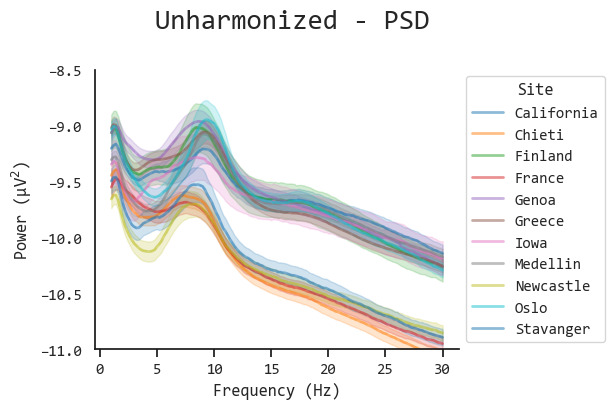

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

def plot_channel_power(df, fig_title= '', plot_variable = '', group_by = '', ylim = (-11, -8.5), legend_title = ''):
    plt.figure(figsize=(6, 6))
    sns.set_style("white")
    sns.set(font="Consolas")
    sns.set_style(rc={'axes.facecolor': 'white'})


    # Get unique groups and assign colors from the sns palette
    group_categories = df[group_by].unique()
    palette = sns.color_palette("tab10", len(group_categories))
    color_map = dict(zip(group_categories, palette))

    for group in group_categories:
        group_df = df[df[group_by] == group]
        mean_group = group_df.groupby(['frequency'])[plot_variable].mean()
        std_group = group_df.groupby(['frequency'])[plot_variable].std()
        num_samples = group_df.groupby(['frequency'])[plot_variable].count()
        sem_group = std_group / np.sqrt(num_samples)

        # Get color for the group from the color map
        color = color_map[group]

        # Plot the mean and SEM
        plt.plot(mean_group.index, mean_group.values, linewidth=2, label=group.capitalize(),alpha=0.5, color=color)
        plt.fill_between(mean_group.index, mean_group.values - 1.96 * sem_group.values, mean_group.values + 1.96 * sem_group.values, alpha=0.2, color=color)

        # Plot dashed lines for mean of each center (for each group)
        centers = group_df[group_by].unique()
        for center in centers:
            center_mean = group_df[group_df[group_by] == center].groupby(['frequency'])[plot_variable].mean()
            plt.plot(center_mean.index, center_mean.values, '--', color=color, alpha=0.2)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (μV$^2$)')
    plt.ylim(ylim)
    plt.grid(False)  # Turn off the grid

    plt.legend(loc='center right', bbox_to_anchor=(1.42, 0.5), ncol=1,frameon=True, title= legend_title)

    plt.tight_layout()
    sns.despine()  # Remove the top and right spines
    # Set the spines color and visibility
    ax = plt.gca()  # Get the current axes
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_minor_locator(ticker.FixedLocator([5, 15, 25]))
    ax.tick_params(direction="out", which='both', bottom=True, color='k', length=6)
    plt.suptitle(fig_title, size=20)
    plt.tight_layout(rect=[0, 0.3, 1, 0.99])  # Adjust the rect parameter as needed

    plt.show()


plot_channel_power(unharm_psd, fig_title= 'Unharmonized - PSD', plot_variable='psd', group_by='center', legend_title='Site')


## ANCOVAS for a Particular feature of interest (Robust to heteroscedasticity)

ANCOVA model with robust covariance type

In [ ]:
unharmonized

participant_id   group   age gender      center  permutation_anterior  \
0            c_hc1      oa  54.0      f  california              0.881634   
1           c_hc10      oa  59.0      f  california              0.861288   
2           c_hc18      oa  57.0      m  california              0.830312   
3            c_hc2      oa  50.0      f  california              0.860231   
4           c_hc20      oa  68.0      m  california              0.882190   
..             ...     ...   ...    ...         ...                   ...   
747     sta_D20167  mci_ad  74.0      m   stavanger              0.848277   
748     sta_D20168  mci_ad  70.0      f   stavanger              0.890302   
749     sta_D20169  mci_ad  72.0      m   stavanger              0.868012   
750     sta_D20170  mci_ad  76.0      f   stavanger              0.863776   
751    sta_D20171K      oa  65.0      f   stavanger              0.895817   

     permutation_central  permutation_posterior  sample_ent_anterior  \
0               0.879567               0.854429             1.501858   
1               0.863244               0.843161             1.396132   
2               0.838156               0.813368             1.150590   
3               0.860346               0.839340             1.351004   
4               0.883905               0.872764             1.399324   
..                   ...                    ...                  ...   
747             0.833978               0.794360             1.261963   
748             0.870729               0.878380             1.492439   
749             0.865594               0.852236             1.350316   
750             0.849790               0.853116             1.295706   
751             0.888692               0.878452             1.456370   

     sample_ent_central  ...  imcoh_delta_median  imcoh_delta_iqr  \
0              1.463266  ...            0.296602         0.109166   
1              1.360610  ...            0.302363         0.149103   
2              1.161904  ...            0.289504         0.132101   
3              1.325591  ...            0.325997         0.180697   
4              1.397808  ...            0.279514         0.116944   
..                  ...  ...                 ...              ...   
747            1.199178  ...            0.285106         0.139984   
748            1.379830  ...            0.263658         0.119441   
749            1.349013  ...            0.301349         0.149604   
750            1.280205  ...            0.468241         0.271867   
751            1.410053  ...            0.265038         0.115659   

     imcoh_theta_median  imcoh_theta_iqr  imcoh_alpha_median  imcoh_alpha_iqr  \
0              0.244828         0.120451            0.368746         0.133523   
1              0.300654         0.143249            0.441526         0.221980   
2              0.212879         0.073216            0.428572         0.133568   
3              0.316773         0.134741            0.304761         0.149281   
4              0.369519         0.231635            0.274175         0.120884   
..                  ...              ...                 ...              ...   
747            0.366310         0.166960            0.438412         0.244847   
748            0.251611         0.096303            0.265092         0.126939   
749            0.333836         0.114853            0.507170         0.197947   
750            0.267172         0.113072            0.450696         0.179432   
751            0.248198         0.113148            0.226321         0.111738   

     imcoh_beta_median  imcoh_beta_iqr  imcoh_global_median  imcoh_global_iqr  
0             0.292821        0.073276             0.303344          0.060372  
1             0.377471        0.148169             0.373100          0.118450  
2             0.291364        0.079428             0.307449          0.061529  
3             0.308886        0.114422             0.314338          0.073336  
4           

Set the reference group in the formula

In [ ]:
# Function to fit a robust linear model with 'hc' as reference and return the summary
def fit_robust_model_with_reference(data, feature):
    # Define the formula for the linear model
    formula = f'{feature} ~ C(group, Treatment(reference="ya")) + age + gender'

    # Fit the model with robust standard errors to account for heteroscedasticity
    model = ols(formula, data=data).fit(cov_type='HC3')

    return model


def plot_observed(feature, data, palette):

    # Plotting the observed values
    plt.figure(figsize=(10, 6))
    sns.stripplot(x='group', y=feature, data=data, palette=palette, alpha=0.2, jitter=True)
    sns.pointplot(x='group', y=feature, data=data, join=False, capsize=.1,
                  errorbar='se', errwidth=1, scale=0.6, color='k')

    plt.xlabel('group')
    plt.ylabel(feature)
    plt.title(f'{feature}')
    plt.grid(True)
    ax = plt.gca()  # Get the current axes
    ax.set_facecolor('white')
    # Set spines color
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    ax.set_xticklabels([label.get_text().upper() for label in ax.get_xticklabels()], fontweight='bold')

    # Show the plot

    plt.title('')
    plt.ylabel(feature.capitalize())
    plt.xlabel('')
    # Show the plot
    plt.show()





C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3847244265.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='group', y=feature, data=data, palette=palette, alpha=0.2, jitter=True)
C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3847244265.py:16: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.stripplot(x='group', y=feature, data=data, palette=palette, alpha=0.2, jitter=True)


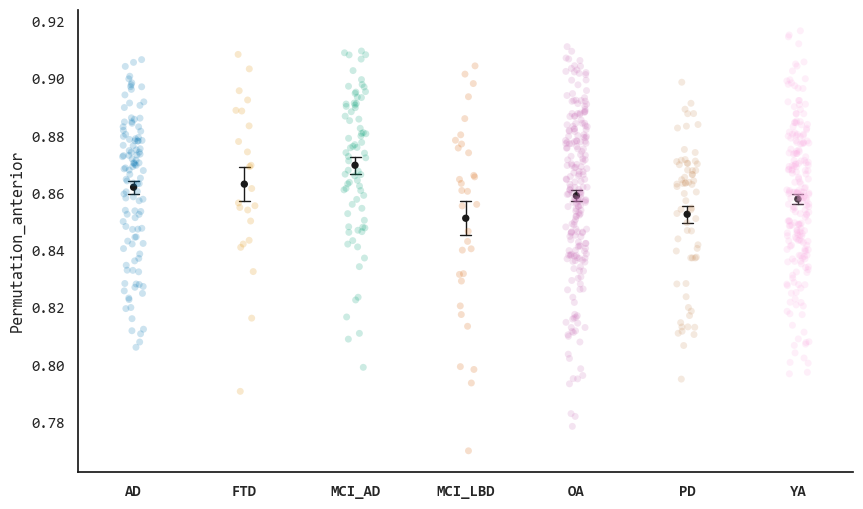

In [ ]:
# Set the color palette to 'colorblind'
# Set the reference category for 'group' to be 'hc'
unharmonized['group'] = pd.Categorical(unharmonized['group'],  ordered=True)

# Set the color palette to 'colorblind'
palette = sns.color_palette("colorblind", len(unharmonized['center'].cat.categories))

model_perm_ent = fit_robust_model_with_reference(unharmonized, 'permutation_anterior')
plot_observed('permutation_anterior', unharmonized, palette)

In [ ]:
# Summary of the model for 'exponent'
model_perm_ent_summary = model_perm_ent.summary()
model_perm_ent_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     permutation_anterior   R-squared:                       0.033
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     3.209
Date:                  Fri, 10 May 2024   Prob (F-statistic):            0.00136
Time:                          16:06:08   Log-Likelihood:                 1668.3
No. Observations:                   752   AIC:                            -3319.
Df Residuals:                       743   BIC:                            -3277.
Df Model:                             8                                         
Covariance Type:                    HC3                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.8611      0.004    231.606      0.000       0.854       0.868
C(group, Treatment(reference="ya"))[T.ad]          0.0043      0.006      0.695      0.487      -0.008       0.016
C(group, Treatment(reference="ya"))[T.ftd]         0.0063      0.008      0.818      0.414      -0.009       0.021
C(group, Treatment(reference="ya"))[T.mci_ad]      0.0124      0.006      1.982      0.048       0.000       0.025
C(group, Treatment(reference="ya"))[T.mci_lbd]    -0.0048      0.008     -0.593      0.553      -0.021       0.011
C(group, Treatment(reference="ya"))[T.oa]          0.0018      0.005      0.347      0.728      -0.009       0.012
C(group, Treatment(reference="ya"))[T.pd]         -0.0046      0.006     -0.817      0.414      -0.016       0.007
gender[T.m]                                       -0.0040      0.002     -2.052      0.040      -0.008      -0.000
age                                            -2.737e-05      0.000     -0.233      0.815      -0.000       0.000
==============================================================================
Omnibus:                       21.991   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.356
Skew:                          -0.423   Prob(JB):                     8.48e-06
Kurtosis:                       2.829   Cond. No.                         864.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

C:\Users\data_analysis\AppData\Local\Temp\ipykernel_24984\3965435479.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()])


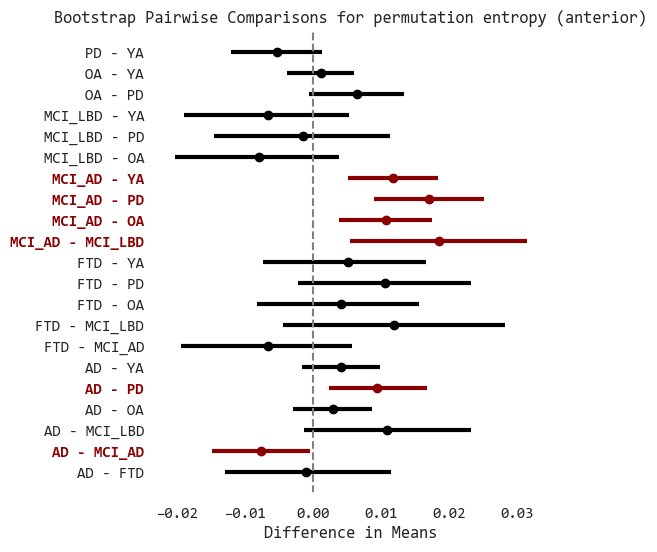

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modify the bootstrap function to return mean differences as well
def bootstrap_pairwise_comparisons(data, feature, groups, num_bootstrap=10000, alpha=0.05):
    group_combinations = [(g1, g2) for i, g1 in enumerate(groups) for g2 in groups[i+1:]]
    bootstrap_results = []

    for g1, g2 in group_combinations:
        group1_data = data[data['group'] == g1][feature]
        group2_data = data[data['group'] == g2][feature]
        mean_diffs = []

        for _ in range(num_bootstrap):
            sample1 = np.random.choice(group1_data, size=len(group1_data), replace=True)
            sample2 = np.random.choice(group2_data, size=len(group2_data), replace=True)
            mean_diffs.append(np.mean(sample1) - np.mean(sample2))

        mean_diff = np.mean(mean_diffs)
        lower_bound = np.percentile(mean_diffs, 100*alpha/2)
        upper_bound = np.percentile(mean_diffs, 100*(1-alpha/2))
        bootstrap_results.append([f"{g1} - {g2}", mean_diff, lower_bound, upper_bound])

    return pd.DataFrame(bootstrap_results, columns=['Group Pair', 'Mean Difference', 'Lower Bound', 'Upper Bound'])


# Generate bootstrap results
groups = unharmonized['group'].cat.categories

# Generate bootstrap results
bootstrap_results_df = bootstrap_pairwise_comparisons(unharmonized, 'permutation_anterior', groups)

# Plotting
plt.figure(figsize=(5, 6))
ax = plt.gca()

# List to store labels for significant comparisons
significant_labels = []

# Iterate through the rows to plot each pair
for _, row in bootstrap_results_df.iterrows():
    is_significant = row['Lower Bound'] > 0 or row['Upper Bound'] < 0
    color = 'darkred' if is_significant else 'black'
    if is_significant:
        significant_labels.append(row['Group Pair'].upper())
    plt.errorbar(x=row['Mean Difference'],
                 y=row['Group Pair'],
                 xerr=[[row['Mean Difference'] - row['Lower Bound']],
                       [row['Upper Bound'] - row['Mean Difference']]],
                 fmt='o', color=color, ecolor=color, elinewidth=3, capsize=0)

plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Difference in Means')
plt.ylabel('')
plt.title('Bootstrap Pairwise Comparisons for permutation entropy (anterior)')
ax.set_facecolor('white')
ax.xaxis.grid(False)  # Turn off the vertical grid

# Apply bold font only to significant labels
for label in ax.get_yticklabels():
    if label.get_text().upper() in significant_labels:
        label.set_fontweight('bold')
        label.set_color('darkred')
ax.set_yticklabels([label.get_text().upper() for label in ax.get_yticklabels()])

plt.show()

## Autogluon autoEDA

Detect covariate shift

In [ ]:
import autogluon.eda.auto as auto

target_col='group'
auto.covariate_shift_detection(train_data=X_train_harmonized, test_data=X_test_harmonized, label=target_col)

We did not detect a substantial difference between the training and test X distributions.

Cluster features

**`train_data` dataset summary**

count  unique top freq       mean       std       min  \
age                      437      94           69.357666  9.175949      46.0   
approximate_anterior     437     436            1.098609  0.108304  0.775222   
approximate_central      437     437            1.108278  0.099346  0.777082   
approximate_posterior    437     437            1.043491  0.117338  0.776819   
beta_bw_anterior         437     436            3.761553  1.371351  0.662923   
...                      ...     ...  ..  ...        ...       ...       ...   
wpli_delta_median        437     437            0.310693  0.053349  0.207019   
wpli_global_iqr          437     437            0.071614  0.018297  0.028953   
wpli_global_median       437     437             0.32032  0.031914  0.249802   
wpli_theta_iqr           437     437            0.162667  0.059891  0.056904   
wpli_theta_median        437     437            0.347285  0.072985  0.217141   

                            25%       50%       75%       max   dtypes  \
age                        63.0      70.0      76.0      89.0  float64   
approximate_anterior   1.023007  1.111371  1.170303  1.346594  float64   
approximate_central    1.048359  1.121457  1.185405  1.301963  float64   
approximate_posterior  0.955437  1.052495   1.13844  1.303988  float64   
beta_bw_anterior       2.786041  3.488563  4.709303   8.38573  float64   
...                         ...       ...       ...       ...      ...   
wpli_delta_median      0.270261   0.30145  0.340847  0.499488  float64   
wpli_global_iqr        0.058527  0.069138  0.081615   0.14713  float64   
wpli_global_median      0.29922  0.318711  0.339188  0.430028  float64   
wpli_theta_iqr         0.121302  0.151805  0.189901  0.402003  float64   
wpli_theta_median      0.292712  0.335649  0.391015  0.610808  float64   

                      missing_count missing_ratio raw_type variable_type  \
age                                                  float       numeric   
approximate_anterior                                 float       numeric   
approximate_central                                  float       numeric   
approximate_posterior                                float       numeric   
beta_bw_anterior                                     float       numeric   
...                             ...           ...      ...           ...   
wpli_delta_median                                    float       numeric   
wpli_global_iqr                                      float       numeric   
wpli_global_median                                   float       numeric   
wpli_theta_iqr                                       float       numeric   
wpli_theta_median                                    float       numeric   

                      special_types  
age                                  
approximate_anterior                 
approximate_central                  
approximate_posterior                
beta_bw_anterior                     
...                             ...  
wpli_delta_median                    
wpli_global_iqr                      
wpli_global_median                   
wpli_theta_iqr                       
wpli_theta_median                    

[109 rows x 17 columns]

**`test_data` dataset summary**

count  unique top freq       mean       std       min  \
age                      188      60           70.148936  9.430588      46.0   
approximate_anterior     188     188            1.098026  0.114546  0.787035   
approximate_central      188     188            1.110637  0.110556  0.729286   
approximate_posterior    188     188            1.046774  0.136082  0.714318   
beta_bw_anterior         188     188            3.844838  1.510272  0.733159   
...                      ...     ...  ..  ...        ...       ...       ...   
wpli_delta_median        188     188            0.306629  0.050978  0.204497   
wpli_global_iqr          188     188            0.072563  0.022938  0.032079   
wpli_global_median       188     188             0.31848  0.034198  0.241097   
wpli_theta_iqr           188     188            0.160521  0.056586  0.056174   
wpli_theta_median        188     188            0.345893  0.074488    0.1656   

                            25%       50%       75%       max   dtypes  \
age                      63.925      71.0      77.0      89.0  float64   
approximate_anterior   1.024139  1.116355  1.183116  1.302652  float64   
approximate_central    1.049025  1.116627  1.195786  1.338634  float64   
approximate_posterior   0.95937  1.053428  1.147663   1.31383  float64   
beta_bw_anterior       2.735206  3.571749  4.809018  9.120888  float64   
...                         ...       ...       ...       ...      ...   
wpli_delta_median      0.273263  0.298247  0.334148  0.519314  float64   
wpli_global_iqr        0.056914  0.067299  0.081942  0.167281  float64   
wpli_global_median     0.294642  0.313521  0.337998  0.473669  float64   
wpli_theta_iqr         0.117144  0.149758  0.189355  0.327451  float64   
wpli_theta_median      0.293559  0.337211  0.388837  0.618232  float64   

                      missing_count missing_ratio raw_type variable_type  \
age                                                  float       numeric   
approximate_anterior                                 float       numeric   
approximate_central                                  float       numeric   
approximate_posterior                                float       numeric   
beta_bw_anterior                                     float       numeric   
...                             ...           ...      ...           ...   
wpli_delta_median                                    float       numeric   
wpli_global_iqr                                      float       numeric   
wpli_global_median                                   float       numeric   
wpli_theta_iqr                                       float       numeric   
wpli_theta_median                                    float       numeric   

                      special_types  
age                                  
approximate_anterior                 
approximate_central                  
approximate_posterior                
beta_bw_anterior                     
...                             ...  
wpli_delta_median                    
wpli_global_iqr                      
wpli_global_median                   
wpli_theta_iqr                       
wpli_theta_median                    

[109 rows x 17 columns]

### Feature Distance

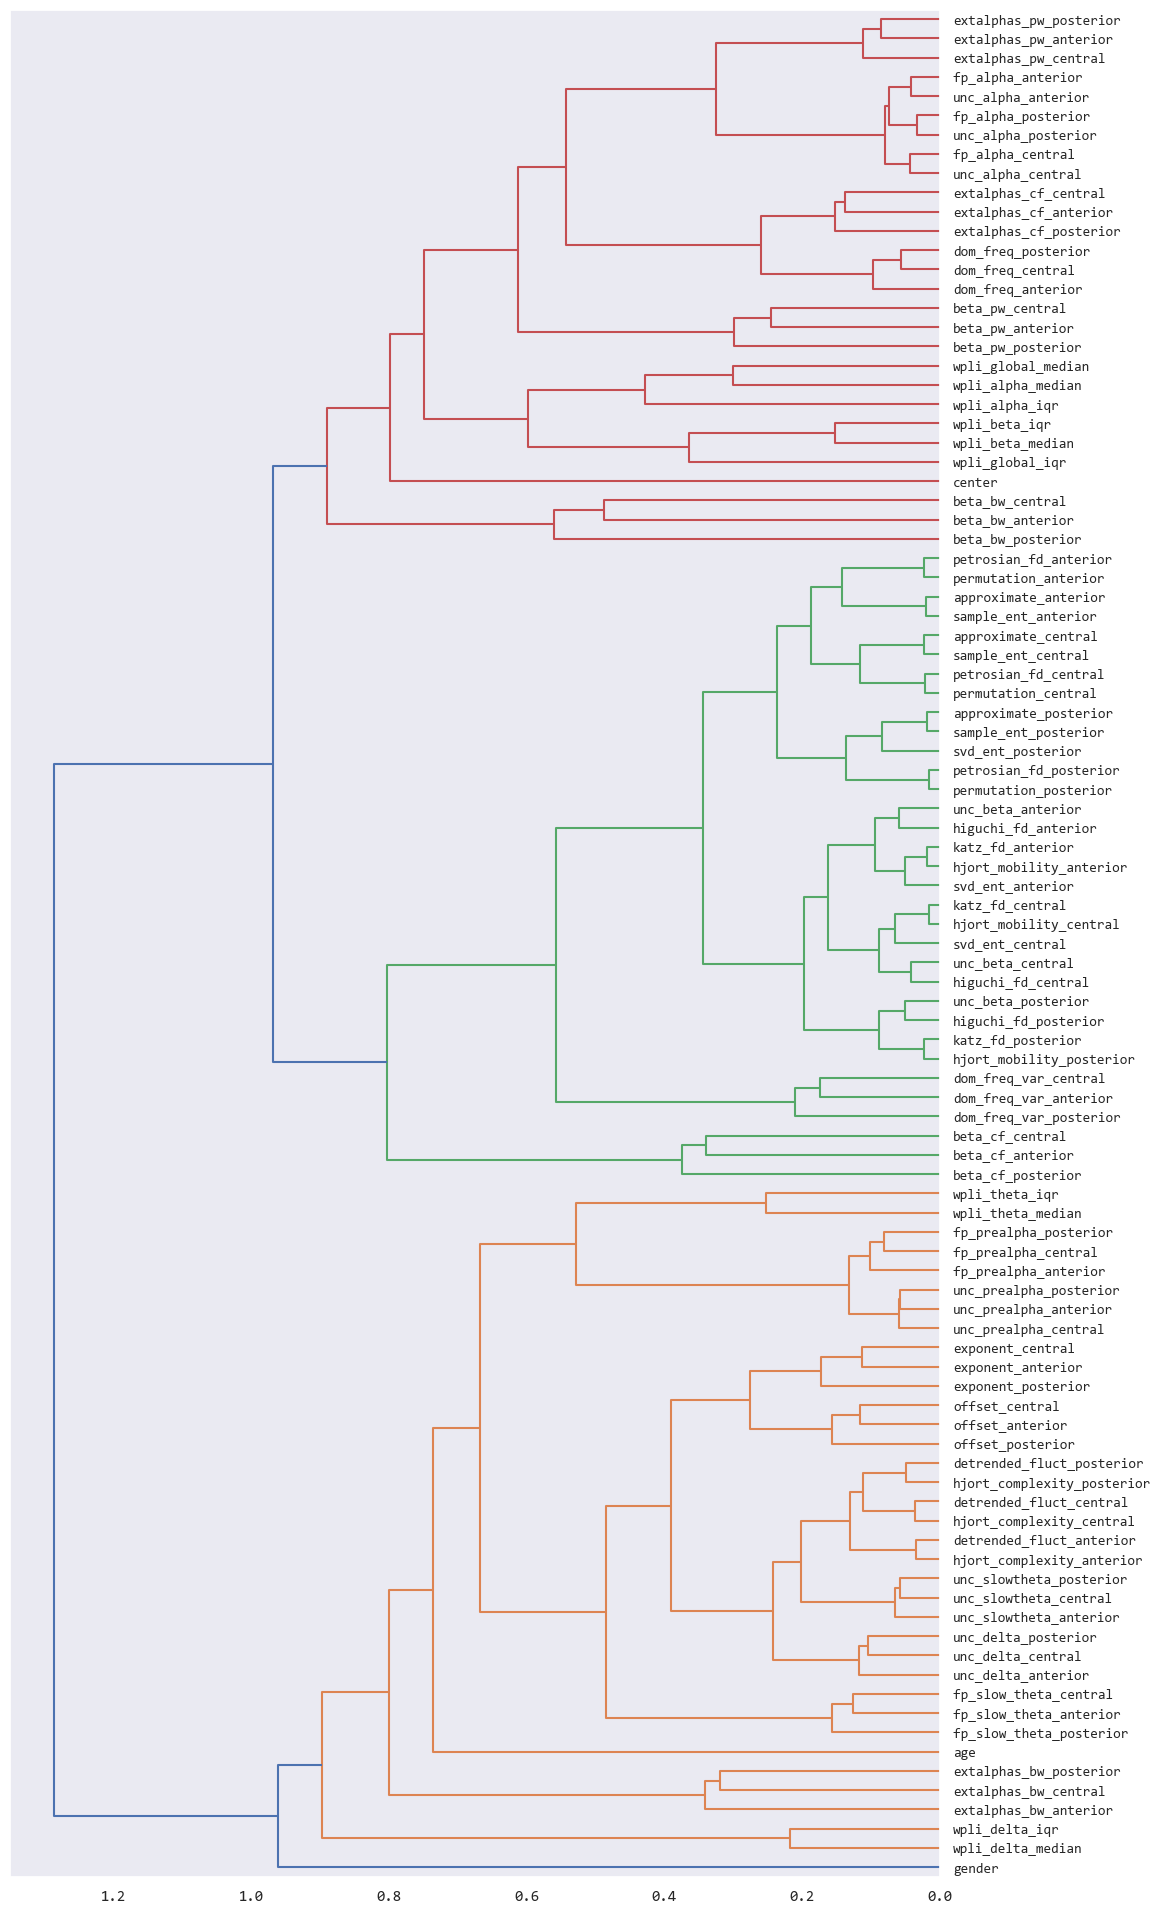

In [ ]:
import autogluon.eda.auto as auto

auto.dataset_overview(train_data=X_train_harmonized, test_data=X_test_harmonized, label=target_col)